# EMCal Clustering Studies in DarkQuest
document the code for studing the emcal clustering in DarkQuest (based on EMCALClusters.ipynb).

Included are the selections on the minimum energy deposits per cell, clustering algorithm, clustered size and energy response and resolutions.

## Signal samples and EMCal
The simulated signal samples are based on https://arxiv.org/pdf/1804.00661.pdf. Figure 4 shows the electron energy spectrum from the Aprime decay.

EMCal is a lead+scintillator sampling calorimeter taken from the PHENIX experiment: https://www.sciencedirect.com/science/article/pii/S016890020201954X. The sampling fraction is about 10%. The moliere radius of lead is 1.6cm. The size of one readout tower is about 5.535x5.535cm, about 3.45R_M, which should contain about 97% of the electron energy deposit.

## Clustering algorithms
Information about different clustering algorithms can be found from: https://scikit-learn.org/stable/modules/clustering.html. The current code uses Birch clustering algorithm. Thanks to the well separations of the two electron showers, all three algorithms seem to get the clustering energy roughly correct. Most differences come from the edges, which usually has low energy deposits and does not affect too much the energy resolution.

## Variable explanations
Some explanation of the used variables in the current ntuple:
- `ge` is the generated electron energy from the Aprime (at the generator level?);
- `n_showers` is the number of showers in the EMCal at the simulation level; 
- `sedep_ecal` is the truth electron energy deposit in the active part of EMCal, by identifying and summing over all the truth EMCal hits in the active part; in some cases there are `n_showers=2` but the `sedep_ecal` is zero, need to understand why;
- `hit_detID` is the corresponding detector ID of the simhits, the mapping can be found here: https://github.com/E1039-Collaboration/e1039-core/blob/master/packages/geom_svc/GeomSvc.cxx#L247-L347. detId=100 is the EMCal ID;
- `hit_edep`, and `hit_elmID` is the simhit energy deposit in the EMCal, and the corresponding EMCal tower ID. **In the current ntuple there does not exist two simhits having the same elmID, so simhit is the same as readout tower**

## ToDos
1. Maybe sort the simhits list by energy would help the clustering?
2. The current clustering algorithm runs pretty slow - ok for studying EMCal performance on a few samples; not good for large production. need to think about how to speed things up
3. the response plot looks reasonable; however, the resolution distribution looks strange - it should follow the stochastic term: sigma/E=a/sqrt(E). Need to understand why; maybe start with adding error bars in the mean and resolution distributions

In [1]:
import uproot3
import numpy as np
import numba
import awkward1 as ak
import awkward as ak0

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.CMS)
import os,sys
import pandas as pd
from scipy.stats import halfnorm
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from scipy.stats import binned_statistic

Basic class to define the EMCAL geometry information

In [2]:
class EMCal(object):
    """
    define the EMCal Geometry
    """
    def __init__(self):
        self.ntowersx=72
        self.ntowersy=36
        self.sizex=5.53 # in cm
        self.sizey=5.53 # in cm

        self.ecalx=[-200,200] #size in cm
        self.ecaly=[-100,100]
        self.binsx=self.ecalx[1]- self.ecalx[0]
        self.binsy=self.ecaly[1]- self.ecaly[0]

Basic class defining the EMCAL clustering algorithm, plot the EMCal shower shapes, and return the clustered tower labels

In [3]:
class EMClustering(object):
    """
    defines the EMCal clustering algorithm and the performance
    """
    def __init__(self, cells_x, cells_y, cells_e, ge, ifile="sim_eval_Brem_0.033428_z500_600_eps_-5.2.root", evtNum=0):
        # x, y and energy information of the cells
        # in np array
        self.cells_x = cells_x
        self.cells_y = cells_y
        self.cells_e = cells_e
        
        # electron energy
        self.ge = ge
        
        self.Mass=ifile.split("/")[-1].split("_")[3]+" GeV"
        self.Type=ifile.split("/")[-1].split("_")[2]
        self.evtNum = evtNum
        
        self.emcal = EMCal()
        
    def plotCount(self):
        # Plot x and y from towers
        fig = plt.figure(figsize=(8,6))
        plt.hist2d(np.array(self.cells_x),np.array(self.cells_y), bins=[int(self.emcal.binsx/self.emcal.sizex),int(self.emcal.binsy/self.emcal.sizey)], range=[self.emcal.ecalx,self.emcal.ecaly], density=False, norm=colors.LogNorm())
        plt.xlabel("Tower x")
        plt.ylabel("Tower y")
        cbar=plt.colorbar()
        cbar.set_label('Counts')
        plt.title("Unweighted Counts for "+self.Type+": "+self.Mass+" \n Event "+str(self.evtNum))
        plt.show()
        
    def plotEnergy(self):
        # weighted
        fig = plt.figure(figsize=(8,6))
        emcal = EMCal()
        plt.hist2d(np.array(self.cells_x),np.array(self.cells_y), bins=[int(self.emcal.binsx/self.emcal.sizex),int(self.emcal.binsy/self.emcal.sizey)], range=[self.emcal.ecalx,self.emcal.ecaly], weights=np.array(self.cells_e)*1e3, density=False, norm=colors.LogNorm())
        plt.xlabel("EMCal X [cm]")
        plt.ylabel("EMCal Y [cm]")
        cbar=plt.colorbar()
        cbar.set_label('Energy Deposit [MeV]')
        #plt.title("Energy Deposits for "+self.Type+": "+self.Mass+" \n Event "+str(self.evtNum))
        plt.show()
        
    def performClustering(self, algo = 0, makePlot = False):
        X = np.vstack((np.array(self.cells_x), np.array(self.cells_y))).T
        funcNames = {}
        funcNames[0] = "BirchClustering"
        funcNames[1] = "KMeansClustering"
        funcNames[2] = "DBSCANClustering"
        labels = getattr(self, funcNames[algo])(X)
        if len(labels)==2:
            # KMeansClustering returns both the clustering labels and the clustered centers
            labels, centers = labels[0], labels[1]
        
        clusters = np.unique(labels)
        energies = np.zeros(clusters.shape[0])
        sizes = np.zeros(clusters.shape[0])
        sizes_cut = np.zeros(clusters.shape[0])
        icluster = 0
        for cluster in clusters:
            # get row indexes for samples with this cluster
            row_ix = np.where(labels == cluster)
            energies[icluster] = np.sum(self.cells_e[row_ix])
            sizes[icluster] = np.sum(self.cells_e[row_ix]>0)
            sizes_cut[icluster] = np.sum(self.cells_e[row_ix]/energies[icluster]>0.01)
            icluster += 1
            
        # show the plot
        if makePlot:
            # create scatter plot for samples from each cluster
            fig = plt.figure(figsize=(8,6))
            for cluster in clusters:
                # get row indexes for samples with this cluster
                row_ix = np.where(labels == cluster)
                # create scatter of these samples
                plt.scatter(X[row_ix, 0], X[row_ix, 1])
            plt.xlabel("EMCal X [cm]")
            plt.ylabel("EMCal Y [cm]")
            plt.xlim(self.emcal.ecalx[0],self.emcal.ecalx[1])
            plt.ylim(self.emcal.ecaly[0],self.emcal.ecaly[1])
            plt.show()    
    
        #print("number of clusters after Birch clustering: ", clusters.shape[0])
        #print("number of cells with energy deposits:", np.sum(self.cells_e>0))
        #print("energy of the clusters: ", energies)
        #print("truth deposits: ", self.ge)
        #print("size of the clusters: ", sizes)
        #print("Finished Birch Clustering...")
        #print("*"*50)
        return energies, sizes, sizes_cut
        
    def BirchClustering(self, X):
        # try birch clusters without considering weights by energy
        #print("start Birch clustering")
        brc = Birch(threshold=20, n_clusters=None)
        brc.fit(X)
        return brc.labels_
        
    def KMeansClustering(self, X):
        # try kmeans clusters with energy weights
        # returns the labels adn cluster_centers
        energy_weights = np.divide(np.array(self.cells_e),np.max(self.cells_e))
        kmeans = KMeans(n_clusters=2, random_state=0, max_iter=1000)
        Y = energy_weights
        wt_kmeansclus = kmeans.fit(X, sample_weight = Y)
        return wt_kmeansclus.labels_, wt_kmeansclus.cluster_centers_
    
    def DBSCANClustering(self,X):
        db = DBSCAN(eps=10, min_samples=1, n_jobs=4)
        clustering = db.fit(X)
        return clustering.labels_

Read data from root and save them in awkward arrays

In [4]:
def getData(fname="", procName="Truth"):
    dq_dict = uproot3.open(fname)["Truth"].arrays()
    dq_dict_ak1 = {name.decode(): ak.from_awkward0(array) for name, array in dq_dict.items()}
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict_ak1["hit_detID"],
                                      "edep":    dq_dict_ak1["hit_edep"],
                                      "elmID":   dq_dict_ak1["hit_elmID"],
                                      "truthx":  dq_dict_ak1["hit_truthx"],
                                      "truthy":  dq_dict_ak1["hit_truthy"],
                                      "truthz":  dq_dict_ak1["hit_truthz"],
                                      }),
                        "Electrons":ak.zip({
                                            "ge":      dq_dict_ak1["ge"],
                                        }),
                        "Showers": ak.zip({
                                            "nshowers":   dq_dict_ak1["n_showers"],
                                            "sedep_ecal": dq_dict_ak1["sedep_ecal"],
                                        }),
                       }, depth_limit=1)
    return dq_events

Some selections to select EMCal simhits, etc

In [5]:
def emcal_simhit_selection(arr):
    mask = (arr.detID == 100)
    return mask

def emcal_simhit_selection_energy(arr, e):
    mask = (arr.edep >= e)
    return mask

def h2_selection(arr):
    mask = (arr.detID >= 35) & (arr.detID <= 38)
    return mask

def st2_selection(arr):
    mask = (arr.detID >= 13) & (arr.detID <= 18)
    return mask

def st3_selection(arr):
    mask = (arr.detID >= 19) & (arr.detID <= 30)
    return mask

def h4_selection(arr):
    mask = (arr.detID >= 41) & (arr.detID <= 46)
    return mask

In [6]:
def printemcalsimhits_byevent(ifile):
    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events["Hits"]
    ecal_mask = ak.any(dq_hits.detID == 100, axis=1)
    ecal_index = np.where(ecal_mask)
    print('Fraction of events with hits reaching EMCAL: ',len(ecal_index[0])/len(dq_events))
    print("Let's print the evt numbers we can use to plot EMCAL clusters")
    print('Indices of evts w. EMCAL hits:',ecal_index)
    return ecal_index

In [7]:
def printemcalshowers_byevent(ifile):
    dq_events = getData(ifile,"Truth")
    dq_showers = dq_events["Showers"]
    dq_electrons = dq_events["Electrons"]
    dq_hits = dq_events["Hits"]
    ecal_mask = ak.any(dq_showers.nshowers == 2,axis=1) & ak.any(dq_showers.sedep_ecal > 0, axis=1) & ak.any(dq_hits.detID == 100, axis=1)
    #ecal_mask = ak.any(dq_showers.nshowers == 2,axis=1) & (ak.max(dq_showers.sedep_ecal, axis=1) > 0.01*ak.min(dq_electrons.ge, axis=1))
    #ecal_mask = ak.all(dq_showers.sedep_ecal > 0, axis=1)
    ecal_index = np.where(ecal_mask)
    print('Fraction of events with \x1b[31mTWO\033[0m showers reaching EMCAL: ',len(ecal_index[0])/len(dq_events))
    print("Let's print the evt numbers we can use to plot EMCAL clusters")
    print('Indices of evts w. EMCAL hits:',ecal_index)
    return ecal_index[0]

In [8]:
def ClusterEvent(ifile, evtNum, algo=0, makePlot=False, emin=0.0005):
    # run the clustering algorithm on one event
    # ifile is the input file name
    # evtNum is the event number that will be clustered
    # algo is the algorithm used for clustering
    # makePlot decides if the energy deposit and clustered plot will be plotted
    # emin is the mimimum energy cut on the simhits, unit in MeV
    
    #print("filename ", ifile)
    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events[evtNum]["Hits"]
    dq_electrons = dq_events[evtNum]["Electrons"]
    dq_showers = dq_events[evtNum]["Showers"]
    
    ge = ak.to_list(dq_electrons.ge)
    showers = ak.to_list(dq_showers.sedep_ecal)
    #print("electron energy: ", ge)
    #print("showers: ", showers)
    
    # select emcal hits
    emcal_mask = emcal_simhit_selection(dq_hits)
    emcal_hits = dq_hits[emcal_mask]
    emcal_energy_mask = emcal_simhit_selection_energy(emcal_hits, emin)
    emcal_hits = emcal_hits[emcal_energy_mask]
    
    emcal = EMCal()
    emcal_towerx = emcal_hits.elmID//emcal.ntowersy
    emcal_towery = emcal_hits.elmID%emcal.ntowersy
    emcal_truthx = emcal_hits.truthx
    emcal_truthy = emcal_hits.truthy
    emcal_x = emcal.ecalx[0]+emcal_towerx*emcal.sizex
    emcal_y = emcal.ecaly[0]+emcal_towery*emcal.sizey
    emcal_edep = emcal_hits.edep
    
    #print("emcal_x",emcal_x,ak.size(emcal_x))
    
    #st3_mask = st3_selection(dq_hits)
    #st3_hits = dq_hits[st3_mask]

    #st2_mask = st2_selection(dq_hits)
    #st2_hits = dq_hits[st2_mask]
    #st2_truthx = st2_hits.truthx
    #st2_truthy = st2_hits.truthy
    
    #h2_mask = h2_selection(dq_hits)
    #h2_hits = dq_hits[h2_mask]
    
    #print("St3 hits %i, St2 hits %i, H2 hits %i"%(len(st3_hits),len(st2_hits),len(h2_hits)))
    #print("Event "+str(evtNum)+": "+str(len(emcal_hits))+" hits")
    
    if ak.size(emcal_x)==0:
        print("For EvtNum {}, no EMCAL SimHits passing the selection. Skip clustering, return 0 clustered energy and 0 clustered size".format(evtNum))
        return ge, showers, [0],[0]
    
    clustering = EMClustering(emcal_x, emcal_y, emcal_edep, ge, ifile, evtNum)
    #clustering.plotCount()
    if makePlot:
        # plot the 2D simhit energy 
        clustering.plotEnergy()
    energies, sizes, sizes_cut = clustering.performClustering(algo=algo, makePlot=makePlot)
    
    return ge, showers, energies, sizes, sizes_cut

Make some gen level plots

Fraction of events with TWO showers reaching EMCAL:  0.9735
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [0, 1, 2, 3, ... 9996, 9997, 9998, 9999] type='9735 * int64'>,)
9735
electron energy:  [[16.4, 5.22], [5.78, 6.22], [11.8, 0.672, ... 7.6], [25.4, 1.52], [5.04, 8.88]]
showers:  [[1.89, 0.596], [0.688, 0.691], [1.37, 0, ... 0.903], [2.9, 0], [0.371, 0.793]]
dq hits:  [[{detID: 1, edep: 3.4e+38, elmID: 117, ... truthy: -7.8, truthz: 656}]]
emcal hits:  [[{detID: 100, edep: 0.000672, elmID: 1310, ... truthy: 3.4e+38, truthz: 3.4e+38}]]
emcal_hits [0.000672, 0.00367, 7.29e-05, 0.000198, ... 0.000898, 0.00153, 0.000359, 0.00052]
flattern [16.4, 5.22, 5.78, 6.22, 11.8, 0.672, 10.6, ... 7.28, 7.6, 25.4, 1.52, 5.04, 8.88]
to_numpy [16.389006  5.21527   5.777927 ...  1.523373  5.041564  8.879922]


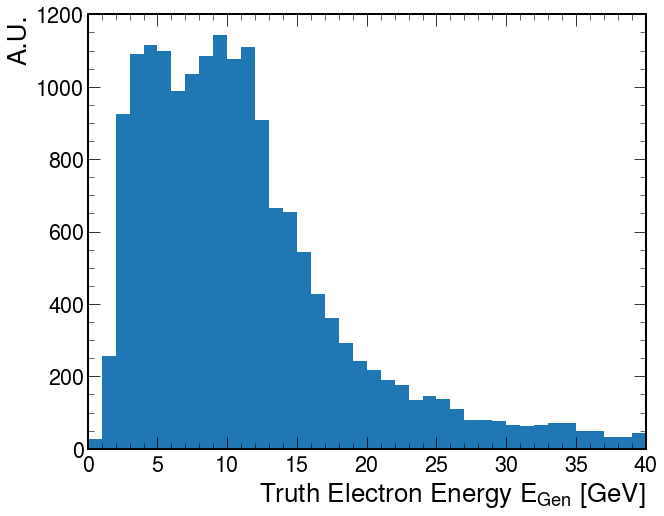

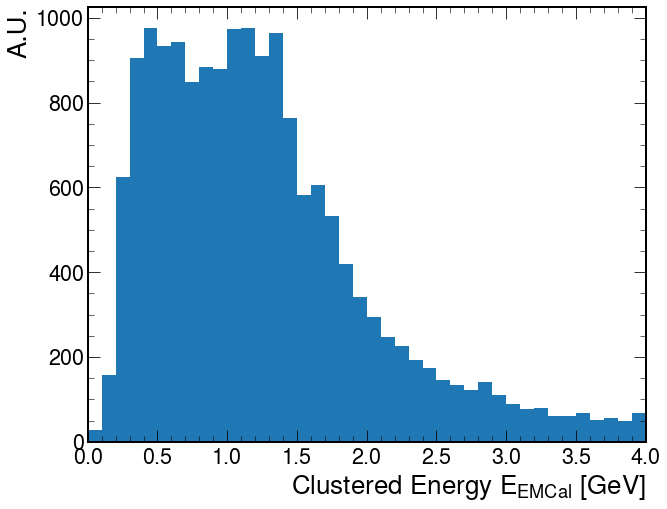

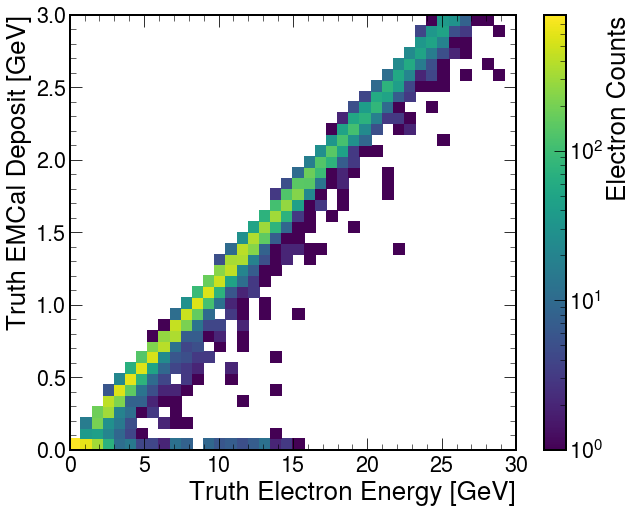

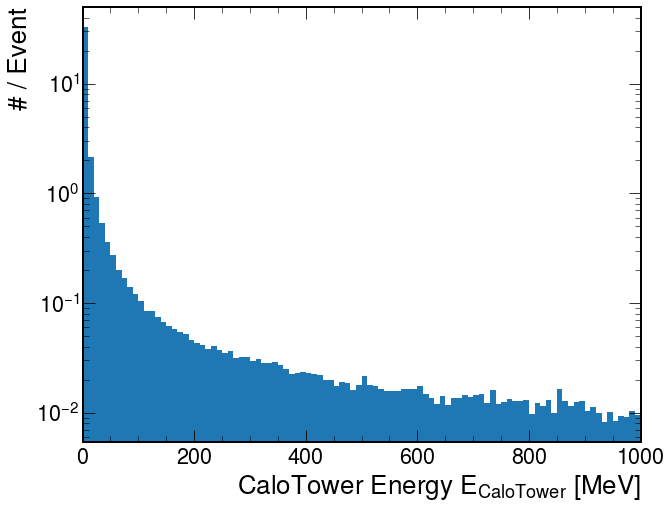

In [19]:
def plotQuantities(ifile):
    #print("filename ", ifile)
    events=printemcalshowers_byevent(ifile)
    print(len(events))
    dq_events = getData(ifile,"Truth")
    dq_hits = dq_events[events]["Hits"]
    dq_electrons = dq_events[events]["Electrons"]
    dq_showers = dq_events[events]["Showers"]
    
    ge = dq_electrons.ge
    showers = dq_showers.sedep_ecal
    print("electron energy: ", ge)
    print("showers: ", showers)
    
    # select emcal simhits
    print("dq hits: ", dq_hits)
    dq_hits = dq_hits[ak.all(showers>0.07*ge, axis=1)]
    emcal_mask = emcal_simhit_selection(dq_hits)
    emcal_hits = dq_hits[emcal_mask]
    print("emcal hits: ", emcal_hits)
    #emcal_energy_mask = emcal_simhit_selection_energy(emcal_hits, 0.0005)
    #emcal_hits = emcal_hits[emcal_energy_mask]
    print("emcal_hits", ak.flatten(emcal_hits.edep,axis=None))
    
    
    # plot the generated electron energy spectrum from the dark photon decay
    # should be close to Figure 4 in https://arxiv.org/pdf/1804.00661.pdf
    fig = plt.figure(figsize=(10,8))
    plt.hist(ak.flatten(ge[showers>0.07*ge],axis=None), bins=40, range=(0,40), density=False)
    plt.xlim(0,40)
    plt.xlabel("Truth Electron Energy $E_{Gen}$ [GeV]")
    plt.ylabel('A.U.')
    plt.savefig("truth_electron_energy.png")
    #plt.ylim(0,8)
    #cbar=plt.colorbar()
    
    # plot the truth electron energy deposits in the EMCal
    # there are some events with two EMCal showers but the emcal energy deposit is zero
    # this is why there is a bump at zero
    fig = plt.figure(figsize=(10,8))
    plt.hist(ak.flatten(showers[showers>0.07*ge],axis=None), bins=40, range=(0,4), density=False)
    plt.xlim(0,4)
    plt.xlabel("Clustered Energy $E_{EMCal}$ [GeV]")
    plt.ylabel('A.U.')
    plt.savefig("truth_emcal_energy.png")
    
    # plot the truth electron energy deposit in the EMCAl vs the truth generated energy
    print("flattern", ak.flatten(ge,axis=None))
    print("to_numpy", ak.to_numpy(ak.flatten(ge,axis=None)))
    fig = plt.figure(figsize=(10,8))
    plt.hist2d(ak.to_numpy(ak.flatten(ge,axis=None)), ak.to_numpy(ak.flatten(showers,axis=None)), bins=[40,40], range=[[0,30], [0,3]], density=False, norm=colors.LogNorm())
    #plt.xlim(0,8)
    #plt.ylim(0,8)
    cbar=plt.colorbar()
    cbar.set_label('Electron Counts')
    plt.xlabel("Truth Electron Energy [GeV]")
    plt.ylabel("Truth EMCal Deposit [GeV]")
    plt.savefig("truth_electron_energy_vs_truth_emcal_energy.png")
    
    # the EMCal simhits energy; simhit is the same as readout tower here
    fig = plt.figure(figsize=(10,8))
    plt.hist(ak.flatten(emcal_hits*1000,axis=None), bins=100, range=(0,1000), density=False, weights=1.0/len(events)*np.ones(len(ak.flatten(emcal_hits*1000,axis=None))))
    plt.xlim(0,1000)
    plt.yscale('log')
    plt.xlabel("CaloTower Energy $E_{CaloTower}$ [MeV]")
    plt.ylabel('# / Event')
    plt.savefig("emcal_simhits.png")
    
    
    
#ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_0.033428_z500_600_eps_-6.root"
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_1.356670_z500_600_eps_-6.root"
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simana_electrons/Brem_0.056739_z500_600_eps_-6.root"
#ifileEta = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simana_electrons/Eta_0.289880_z500_600_eps_-6.root"
plotQuantities(ifileBrem)

Run one quick test of ploting the EMCal energy deposits, the clustering algorithm, and plot the clustered distributions

Fraction of events with TWO showers reaching EMCAL:  0.8265
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [0, 4, 6, 7, ... 9996, 9997, 9998, 9999] type='8265 * int64'>,)
acc:  [0, 4, 6, 7, 9, 10, 11, 12, 13, ... 9990, 9992, 9994, 9995, 9996, 9997, 9998, 9999] 8265


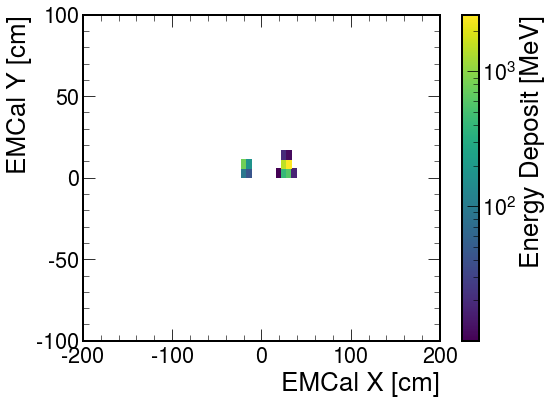

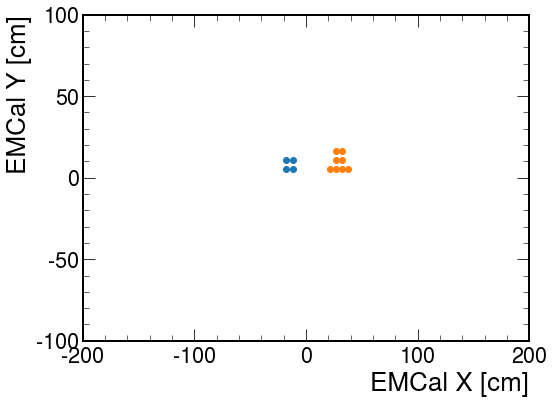

ge [9.768810272216797, 49.755699157714844]
showers [1.1303856372833252, 5.314919948577881]
energies [1.10687935 5.24692822]
sizes [4. 8.]
sizes_cut [4. 4.]


In [17]:
#ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_0.033428_z500_600_eps_-6.root"
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_1.356670_z500_600_eps_-6.root"
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simana_electrons/Brem_0.056739_z500_600_eps_-6.root"
ifileEta = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Eta_0.289880_z500_600_eps_-6.root"
ifileEta = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simana_electrons/Eta_0.289880_z500_600_eps_-6.root"
# this prints the evt numbers w two emcal showers and returns basic acceptance
acc = printemcalshowers_byevent(ifileEta)
print("acc: ", acc, len(acc))

ge, showers, energies, sizes, sizes_cut = ClusterEvent(ifileBrem,30, algo=0, makePlot=True,emin=0.01)
print("ge", ge)
print("showers", showers)
print("energies", energies)
print("sizes", sizes)
print("sizes_cut", sizes_cut)

run the clustering algorithm on all the events (passing selections) of one input sample

In [14]:
'''
#ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_0.033428_z500_600_eps_-6.root"
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_1.356670_z500_600_eps_-6.root"
# this prints the evt numbers w two emcal showers and returns basic acceptance
acc = printemcalshowers_byevent(ifileBrem)
print("acc: ", acc, len(acc))
# this reconstructs preliminary clusters
electron_truth_1st = [] # electron truth energy from production
electron_truth_2nd = []
cluster_truth_1st = []
cluster_truth_2nd = []
cluster_reco_1st = []
cluster_reco_2nd = []
cluster_size_1st = []
cluster_size_2nd = []

for evt in acc:
    if evt > 1000:
       break
    #evt = acc[ievt] 
    if len(electron_truth_1st)%10 == 0:
        print("processed ", len(electron_truth_1st), "events")
    ge, showers, energies, sizes = ClusterEvent(ifileBrem,evt)
    # ge and showers should always have two elements because of the event selections
    #print(ge)
    ge.sort(reverse=True)
    showers.sort(reverse=True)
    reco_energy_size = sorted(zip(energies, sizes),reverse=True)
    #print("electron energies: ", ge)
    #print("showers: ", showers)
    #print("energies: ", energies)
    #print("sizes: ", sizes)
    electron_truth_1st.append(ge[0])
    electron_truth_2nd.append(ge[1])
    cluster_truth_1st.append(showers[0])
    # this might be zero
    cluster_truth_2nd.append(showers[1])
    
    # there is always at least one cluster based on the event selections, 
    # but there might only be on cluster
    cluster_reco_1st.append(reco_energy_size[0][0])
    cluster_size_1st.append(reco_energy_size[0][1])
    if len(reco_energy_size)>1:
        cluster_reco_2nd.append(reco_energy_size[1][0])
        cluster_size_2nd.append(reco_energy_size[1][1])
    else:
        cluster_reco_2nd.append(0)
        cluster_size_2nd.append(0)
    #print("truth cluster: ", cluster_truth_1st+electron_truth_2nd)
    #print("reco cluster: ", cluster_reco_1st+cluster_reco_2nd)
    #print("size cluster ", cluster_size_1st+cluster_size_2nd)
    #break
print("done")
'''

Fraction of events with TWO showers reaching EMCAL:  0.532
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [1, 2, 3, 5, ... 9996, 9997, 9998, 9999] type='5320 * int64'>,)
acc:  [1, 2, 3, 5, 7, 8, 9, 10, 11, ... 9989, 9991, 9992, 9994, 9996, 9997, 9998, 9999] 5320
processed  0 events
processed  10 events
processed  20 events
processed  30 events
processed  40 events
processed  50 events
For EvtNum 100, no EMCAL SimHits passing the selection. Skip clustering, return 0 clustered energy and 0 clustered size
processed  60 events
processed  70 events
processed  80 events
processed  90 events
processed  100 events
processed  110 events
processed  120 events
processed  130 events
processed  140 events
processed  150 events
processed  160 events
processed  170 events
processed  180 events
processed  190 events
processed  200 events
For EvtNum 404, no EMCAL SimHits passing the selection. Skip clustering, return 0 clustered energy and 0 cluster

The above Gen-Reco matching matches the cluster with larger energy to the electron with larger energy; this seems to work fine for the cases where there are two reconstructed electron clusters; but does not work for the events where there is only one cluster.

Instead we try matching the reconstructed cluster E with the smallest difference (ge-E/0.11)

In [59]:
from multiprocessing import Pool
from itertools import repeat

# this reconstructs preliminary clusters
def performclustering(filename, evtlist):
    electron_truth = [] # electron truth energy from production
    cluster_truth = []
    cluster_reco = []
    cluster_size = []
    cluster_size_cut = []
    
    evtlist = evtlist.tolist() if isinstance(evtlist, np.ndarray) else evtlist

    for evt in evtlist:
        #if evt > 1000:
        #   break
        #evt = acc[ievt] 
        if len(electron_truth)%10 == 0:
            #print("processed ", len(electron_truth), "events")
            print("processed {} events".format(len(electron_truth)))
        ge, showers, energies, sizes, sizes_cut = ClusterEvent(filename,evt)
        # ge and showers should always have two elements because of the event selections
        #print(ge)
        ge.sort(reverse=True)
        showers.sort(reverse=True)
        reco_energy_size = sorted(zip(energies, sizes, sizes_cut),reverse=True)

        #print("electron energies: ", ge)
        #print("showers: ", showers)
        #print("energies: ", energies)
        #print("sizes: ", sizes)
    
        # there is always at least one cluster based on the event selections, 
        # but there might only be on cluster; take the 1st one
        cluster_reco.append(reco_energy_size[0][0])
        cluster_size.append(reco_energy_size[0][1])
        cluster_size_cut.append(reco_energy_size[0][2])
        
    
        electron_truth.append(min(ge, key=lambda e:abs(e*0.11-reco_energy_size[0][0])))
        cluster_truth.append(min( showers, key=lambda e:abs(e-reco_energy_size[0][0])))
    return electron_truth, cluster_truth, cluster_reco, cluster_size, cluster_size_cut

def processing(filename, acc):
    #print(isinstance(np.array_split(list(acc)[0:10], 4)[0],np.ndarray))
    nproc = 4
    pool = Pool(nproc)
    results = pool.starmap(performclustering, zip(repeat(filename), np.array_split(list(acc), nproc)))
    return results
#print(results[0])

In [66]:
ifileBrem = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_1.356670_z500_600_eps_-6.root"
#ifileEta = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Eta_0.289880_z500_600_eps_-6.root"
acc = printemcalshowers_byevent(ifileBrem)
acc = acc[0:30]
print("acc: ", acc, len(acc))

results = processing(ifileBrem, acc)

electron_truth_Eta = []
cluster_truth_Eta = []
cluster_reco_Eta = []
cluster_size_Eta = []
cluster_size_cut_Eta = []
nproc = 4
for iproc in range(nproc):
    electron_truth_Eta += results[iproc][0] 
    cluster_truth_Eta += results[iproc][1]
    cluster_reco_Eta += results[iproc][2]
    cluster_size_Eta += results[iproc][3]
    cluster_size_cut_Eta += results[iproc][4]
print("truth electron: ", electron_truth_Eta)
print("truth cluster: ", cluster_truth_Eta)
print("reco cluster: ", cluster_reco_Eta)
print("size cluster ", cluster_size_Eta)
print("size cluster ", cluster_size_cut_Eta)
    #break
print("done")

Fraction of events with TWO showers reaching EMCAL:  0.532
Let's print the evt numbers we can use to plot EMCAL clusters
Indices of evts w. EMCAL hits: (<Array [1, 2, 3, 5, ... 9996, 9997, 9998, 9999] type='5320 * int64'>,)
acc:  [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 16, ... 42, 43, 44, 47, 51, 52, 53, 56, 57, 60, 61] 30
processed 0 eventsprocessed 0 eventsprocessed 0 eventsprocessed 0 events



truth electron:  [21.597339630126953, 48.5275764465332, 22.92707633972168, 24.669462203979492, 22.982059478759766, 6.9244465827941895, 40.67816925048828, 43.72687530517578, 11.09713363647461, 29.530109405517578, 44.67561721801758, 24.12376594543457, 82.32878112792969, 48.776451110839844, 30.853601455688477, 42.97517395019531, 5.254845142364502, 57.227294921875, 31.445608139038086, 55.881473541259766, 11.085982322692871, 70.56201934814453, 36.76375961303711, 31.776517868041992, 7.260765552520752, 29.100191116333008, 16.194660186767578, 79.57146453857422, 64.67233276367188, 8.582381248474121]
truth c

In [166]:
#cluster_energy_array = np.array(cluster_reco_1st  + cluster_reco_2nd)
#cluster_truth_array  = np.array(cluster_truth_1st + cluster_truth_2nd)
#electron_truth_energy_array = np.array(electron_truth_1st + electron_truth_2nd)
# select the ones having more than 50% (sampling fraction 10%), to remove the boundaries
#mask_outliers = np.where(cluster_energy_array>0.05*electron_truth_energy_array)
#cluster_energy_array = cluster_energy_array[mask_outliers]
#electron_truth_energy_array = electron_truth_energy_array[mask_outliers]
#cluster_truth_array = cluster_truth_array[mask_outliers]
#cluster_energy_array = cluster_reco
#electron_truth_energy_array = electron_truth
#cluster_truth_array = cluster_truth
cluster_energy_array_Eta = cluster_reco_Eta
electron_truth_energy_array_Eta = electron_truth_Eta
cluster_truth_array_Eta = cluster_truth_Eta

5037


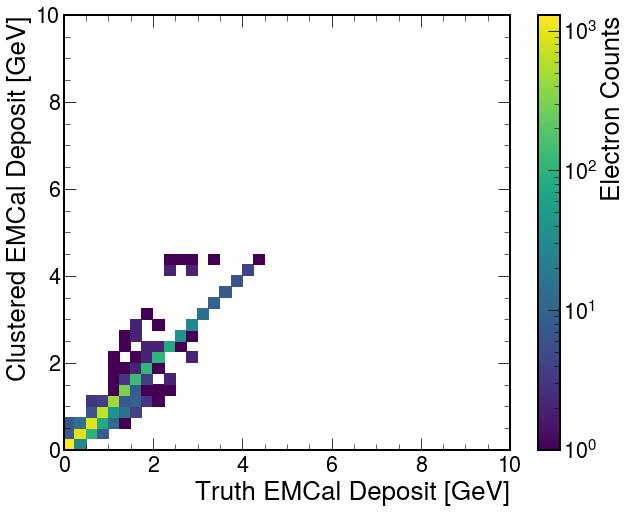

In [167]:
fig = plt.figure(figsize=(10,8))
print(len(cluster_truth_array))
plt.hist2d(cluster_truth_array_Eta, cluster_energy_array_Eta, bins=[40,40], range=[[0,10], [0,10]], density=False, norm=colors.LogNorm())
#plt.xlim(0,8)
#plt.ylim(0,8)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth EMCal Deposit [GeV]")
plt.ylabel("Clustered EMCal Deposit [GeV]")
plt.savefig("Reco_VS_Gen_Energy_large.png")

[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 25. 30. 35. 40.]


Text(0, 1, '$\\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')

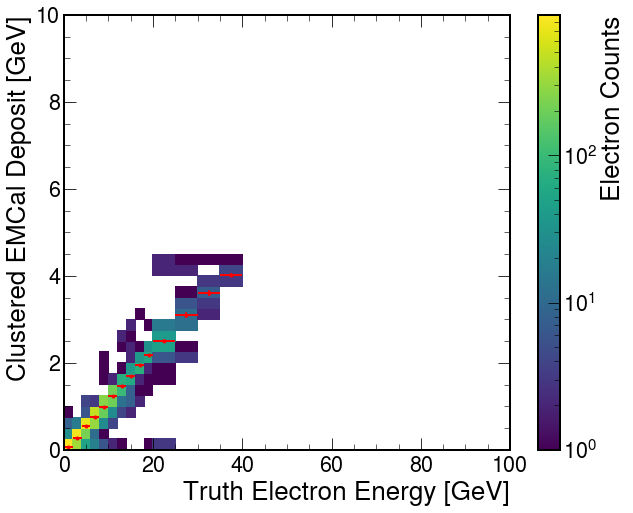

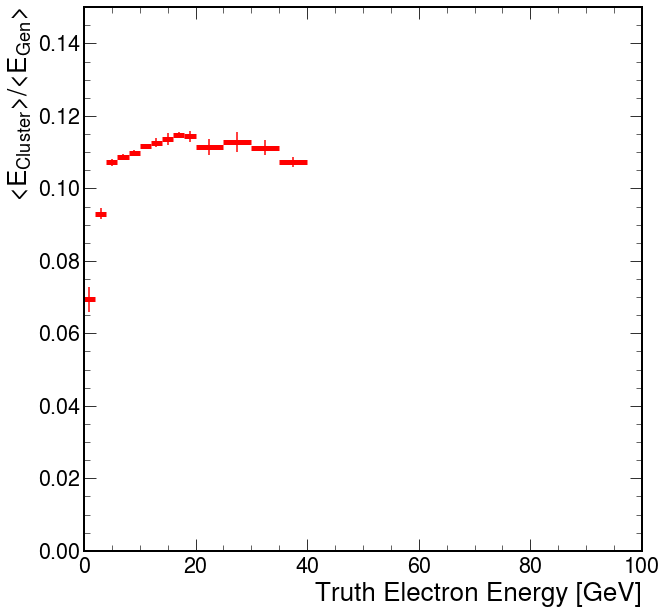

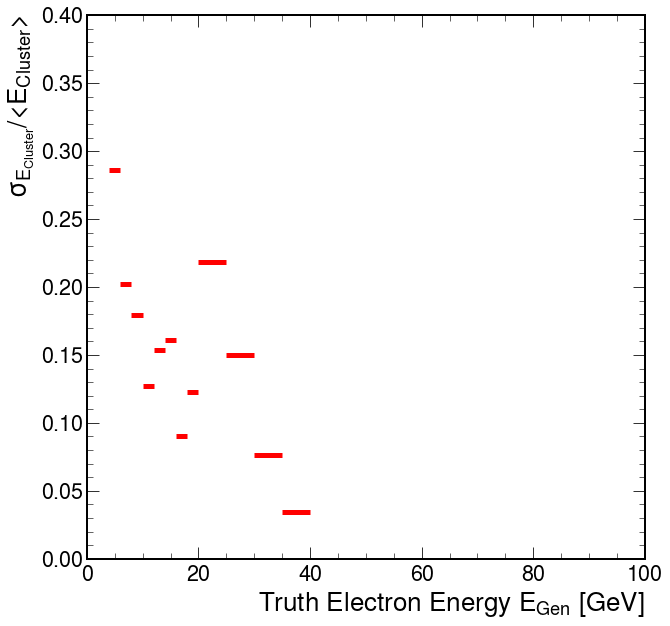

In [172]:
#print(electron_truth)
from scipy.stats import binned_statistic
#print(electron_truth_energy_array)
fig = plt.figure(figsize=(10,8))
#binnings = np.concatenate((np.linspace(0,10,num=11), np.linspace(11,19,num=5),np.linspace(21,31,num=3), np.linspace(41, 101, num=11)))
binnings = np.concatenate((np.linspace(0,20, num=11), np.linspace(25,40,num=4)))
print(binnings)
bin_resols, bin_edges, binnumber = binned_statistic(electron_truth_energy_array_Eta, cluster_energy_array_Eta, statistic='std', bins=binnings, range=(0,100))
bin_means, bin_edges, binnumber = binned_statistic(electron_truth_energy_array_Eta, cluster_energy_array_Eta, statistic='mean', bins=binnings, range=(0,100))
bin_counts, bin_edges, binnumber = binned_statistic(electron_truth_energy_array_Eta, cluster_energy_array_Eta, statistic='count', bins=binnings, range=(0,100))
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
plt.hist2d(electron_truth_energy_array_Eta, cluster_energy_array_Eta, bins=[binnings,40], range=[[0,100], [0,10]], density=False, norm=colors.LogNorm())
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2,
           label='binned statistic of data', linestyles='solid')
plt.errorbar(bin_centers, bin_means, yerr=bin_resols/np.sqrt(bin_counts),marker='.',color='r', linestyle="None")
plt.xlim(0,100)
plt.ylim(0,10)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Deposit [GeV]")
plt.savefig("Reco_VS_GenElectron_Energy.png")

plt.figure()
plt.hlines(bin_means/bin_centers, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.errorbar(bin_centers, bin_means/bin_centers, yerr=bin_resols/(np.sqrt(bin_counts)*bin_centers),marker='.',color='r', linestyle="None")
plt.xlim(0,100.0)
plt.ylim(0,0.15)
plt.xlabel('Truth Electron Energy [GeV]')
plt.ylabel('<$E_{Cluster}$>/<$E_{Gen}$>')

plt.figure()
plt.hlines(bin_resols/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.xlim(0,100.0)
plt.ylim(0,0.4)
plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')

In [14]:
ifile = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Eta_0.438869_z500_600_eps_-6.root"
ifile = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_0.799296_z500_600_eps_-6.root"
ifile = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simana_electrons/Eta_0.289880_z500_600_eps_-6.root"
dq_events = getData(ifile,"Truth")
dq_showers = dq_events["Showers"]
dq_electrons = dq_events["Electrons"]
print("offdiagonal:", ak.where((ak.max(dq_showers.sedep_ecal, axis=1)>0 )& (ak.min(dq_electrons.ge, axis=1)*0.08 > ak.max(dq_showers.sedep_ecal, axis=1)) & (ak.min(dq_electrons.ge, axis=1)*0.05 < ak.max(dq_showers.sedep_ecal, axis=1))))
print("diagonal:", ak.where((ak.max(dq_showers.sedep_ecal, axis=1)>0 )& (ak.min(dq_electrons.ge, axis=1)*0.08 < ak.max(dq_showers.sedep_ecal, axis=1)) & (ak.max(dq_electrons.ge, axis=1)>50.0) ))
ecal_mask = ak.any(dq_showers.nshowers == 2,axis=1)
dq_showers = dq_showers[ecal_mask]
dq_electrons = dq_electrons[ecal_mask]
cluster_energy_truth = ak.flatten(dq_showers.sedep_ecal)
electron_energy_truth = ak.flatten(dq_electrons.ge)
cluster_mask = (cluster_energy_truth > 0.07*electron_energy_truth)
cluster_energy_truth = cluster_energy_truth[cluster_mask]
electron_energy_truth = electron_energy_truth[cluster_mask]
electron_truth_energy_array_Eta = ak.to_list(electron_energy_truth)
cluster_energy_array_Eta = ak.to_list(cluster_energy_truth)

offdiagonal: (<Array [3, 105, 124, 150, ... 9952, 9985, 9991] type='377 * int64'>,)
diagonal: (<Array [3, 1006, 6988, 7364, 8841] type='5 * int64'>,)


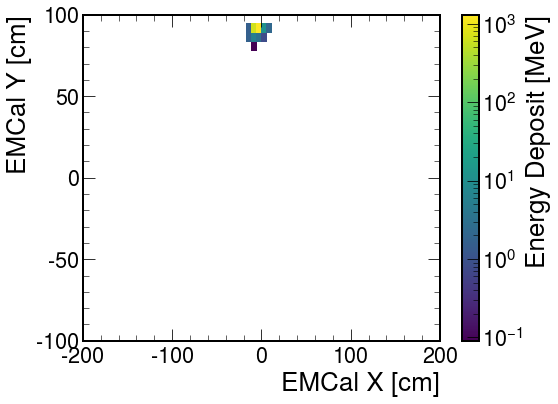

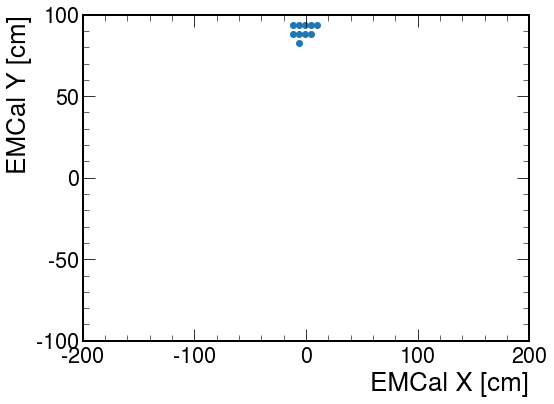

ge [36.28870391845703, 49.1524543762207]
showers [1.9822245836257935, 0.0]
energies [1.98222363]
sizes [10.]


In [47]:
ge, showers, energies, sizes = ClusterEvent(ifile,9142, algo=0, makePlot=True,emin=0.)
print("ge", ge)
print("showers", showers)
print("energies", energies)
print("sizes", sizes)

In [19]:
ifile = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Eta_0.540000_z500_600_eps_-6.root"
dq_events = getData(ifile,"Truth")
dq_showers = dq_events["Showers"]
dq_electrons = dq_events["Electrons"]
ecal_mask = ak.any(dq_showers.nshowers == 2,axis=1)
dq_showers = dq_showers[ecal_mask]
dq_electrons = dq_electrons[ecal_mask]
cluster_energy_truth = ak.flatten(dq_showers.sedep_ecal)
electron_energy_truth = ak.flatten(dq_electrons.ge)
cluster_mask = (cluster_energy_truth > 0.07*electron_energy_truth)
cluster_energy_truth = cluster_energy_truth[cluster_mask]
electron_energy_truth = electron_energy_truth[cluster_mask]
electron_truth_energy_array_Eta2 = ak.to_list(electron_energy_truth)
cluster_energy_array_Eta2 = ak.to_list(cluster_energy_truth)
print(electron_truth_energy_array_Eta2)
print(cluster_energy_array_Eta2)

[13.699570655822754, 17.463659286499023, 7.590872287750244, 23.229433059692383, 6.227848052978516, 7.130046367645264, 28.141332626342773, 28.552021026611328, 21.268369674682617, 9.945740699768066, 5.459117412567139, 3.9306159019470215, 9.809751510620117, 13.117606163024902, 4.317559242248535, 14.186744689941406, 9.834308624267578, 11.794370651245117, 2.229307174682617, 2.886925458908081, 10.16681957244873, 17.323190689086914, 24.723249435424805, 4.556746959686279, 20.087900161743164, 8.035712242126465, 26.10682487487793, 18.677759170532227, 5.770028114318848, 19.13228416442871, 5.356716632843018, 23.48470115661621, 19.315792083740234, 5.564033031463623, 3.9568910598754883, 8.365306854248047, 10.00263500213623, 6.400858402252197, 9.455409049987793, 6.312572956085205, 4.343506813049316, 7.296635150909424, 11.757834434509277, 8.726590156555176, 12.097356796264648, 13.636725425720215, 6.483445644378662, 8.696212768554688, 13.91822338104248, 2.3521528244018555, 6.120718955993652, 11.1505260

In [18]:
ifile = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_1.356670_z500_600_eps_-6.root"
ifile = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_0.799296_z500_600_eps_-6.root"
ifile = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simana_electrons/Brem_0.011603_z500_600_eps_-6.root"
dq_events = getData(ifile,"Truth")
dq_showers = dq_events["Showers"]
dq_electrons = dq_events["Electrons"]
ecal_mask = ak.any(dq_showers.nshowers == 2,axis=1)
dq_showers = dq_showers[ecal_mask]
dq_electrons = dq_electrons[ecal_mask]
cluster_energy_truth = ak.flatten(dq_showers.sedep_ecal)
electron_energy_truth = ak.flatten(dq_electrons.ge)
cluster_mask = (cluster_energy_truth > 0.08*electron_energy_truth)
cluster_energy_truth = cluster_energy_truth[cluster_mask]
electron_energy_truth = electron_energy_truth[cluster_mask]
print("cluster_energy:", cluster_energy_truth)
print("electron_energy: ", electron_energy_truth)
electron_truth_energy_array_Brem = ak.to_list(electron_energy_truth)
cluster_energy_array_Brem = ak.to_list(cluster_energy_truth)

cluster_energy: [1.41, 3.03, 1.05, 0.785, 1.52, 1.45, 0.509, ... 4.94, 1.55, 1.04, 1.86, 0.478, 1.13]
electron_energy:  [11.9, 26.2, 9.02, 6.83, 13.2, 11.9, 4.19, ... 41.6, 13.6, 8.87, 15.6, 4.22, 9.24]


In [19]:
ifile = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simeval_electrons_emcal/sim_eval_Brem_1.356670_z500_600_eps_-6.root"
ifile = "/seaquest/users/cmantill/DarkQuest/e1039-analysis/SimHits/macro/simana_electrons/Brem_0.056739_z500_600_eps_-6.root"
dq_events = getData(ifile,"Truth")
dq_showers = dq_events["Showers"]
dq_electrons = dq_events["Electrons"]
ecal_mask = ak.any(dq_showers.nshowers == 2,axis=1)
dq_showers = dq_showers[ecal_mask]
dq_electrons = dq_electrons[ecal_mask]
cluster_energy_truth = ak.flatten(dq_showers.sedep_ecal)
electron_energy_truth = ak.flatten(dq_electrons.ge)
cluster_mask = (cluster_energy_truth > 0.08*electron_energy_truth)
cluster_energy_truth = cluster_energy_truth[cluster_mask]
electron_energy_truth = electron_energy_truth[cluster_mask]
print("cluster_energy:", cluster_energy_truth)
print("electron_energy: ", electron_energy_truth)
electron_truth_energy_array_Brem2 = ak.to_list(electron_energy_truth)
cluster_energy_array_Brem2 = ak.to_list(cluster_energy_truth)

cluster_energy: [1.89, 0.596, 0.688, 0.691, 1.37, 1.23, ... 1.92, 1.7, 0.873, 0.903, 2.9, 0.793]
electron_energy:  [16.4, 5.22, 5.78, 6.22, 11.8, 10.6, 37.9, ... 4.06, 16.7, 14, 7.28, 7.6, 25.4, 8.88]


In [20]:
#electron_truth_energy_array = electron_truth_energy_array_Eta + electron_truth_energy_array_Eta2 + electron_truth_energy_array_Brem + electron_truth_energy_array_Brem2
#cluster_energy_array = cluster_energy_array_Eta + cluster_energy_array_Eta2 + cluster_energy_array_Brem + cluster_energy_array_Brem2
#electron_truth_energy_array = np.array(electron_truth_energy_array)
#cluster_energy_array = np.array(cluster_energy_array)

electron_truth_energy_array = electron_truth_energy_array_Brem + electron_truth_energy_array_Brem2
cluster_energy_array = cluster_energy_array_Brem + cluster_energy_array_Brem2
electron_truth_energy_array = np.array(electron_truth_energy_array)
cluster_energy_array = np.array(cluster_energy_array)

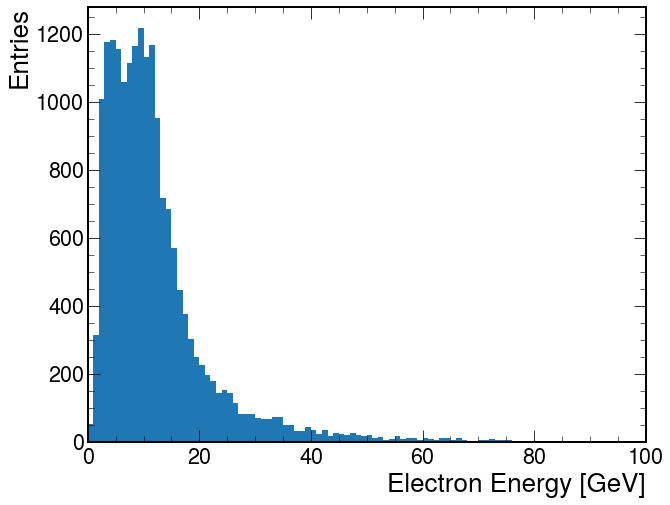

In [58]:
fig = plt.figure(figsize=(10,8))
plt.hist(electron_truth_energy_array, bins=100, range=(0,100), density=False)
plt.xlim(0,100)
plt.xlabel("Electron Energy [GeV]")
plt.ylabel('Entries')
plt.savefig("electron_energy.png")

[  0.   1.   2.   3.   4.   5.   6.   7.   8.  10.  12.  14.  16.  20.
  25.  35.  50.  70. 100.]
digitize [10 15  9 ...  8 15  9]
bin avg:  [ 0.4453267   1.70953624  2.53906414  3.50534321  4.48358894  5.49399588
  6.50576454  7.48495818  9.02338044 11.01609718 12.92455856 14.92358794
 17.73116862 22.27276409 29.34523408 41.25355958 58.15082785 78.56198772]
scale factors  [0.11605123 0.11555774 0.11613951 ... 0.11611137 0.11555774 0.11613951]
[0.00885328 0.0165226  0.01663895 0.02058703 0.02546869 0.02851189
 0.03298404 0.03554175 0.03841219 0.04388539 0.04913994 0.05116664
 0.06027017 0.08240266 0.0865914  0.11960317 0.18030262 0.23945288]
[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 9.0, 11.0, 13.0, 15.0, 18.0, 22.5, 30.0, 42.5] 16
0.00620704681724507 0.07452857538674651
<class 'numpy.ndarray'>
(0.021, 0.081)


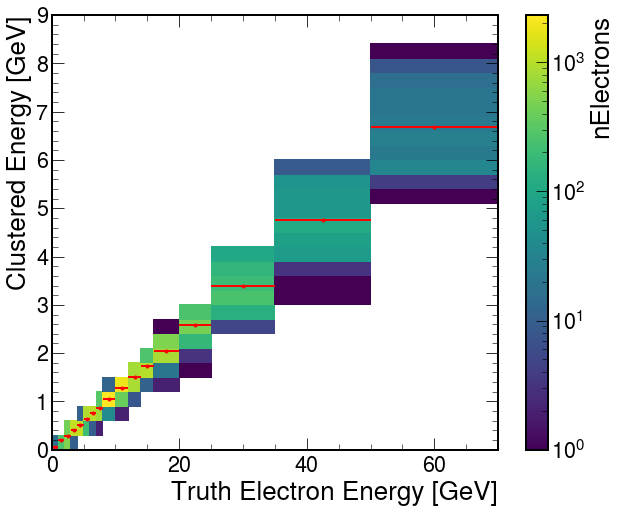

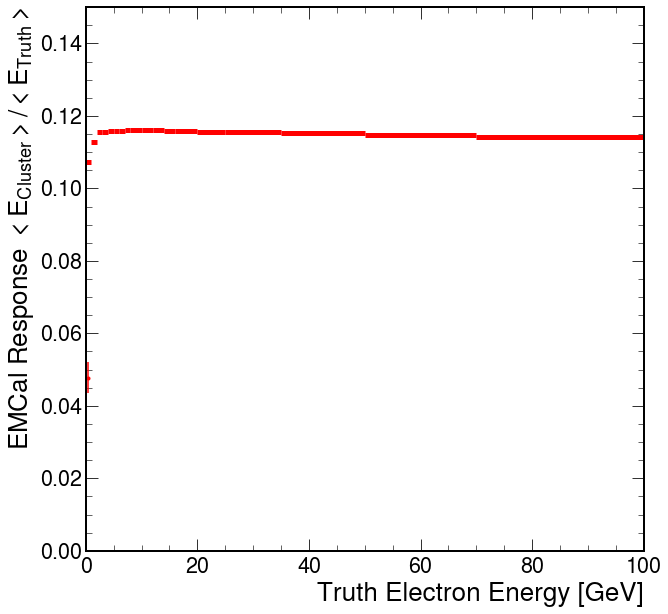

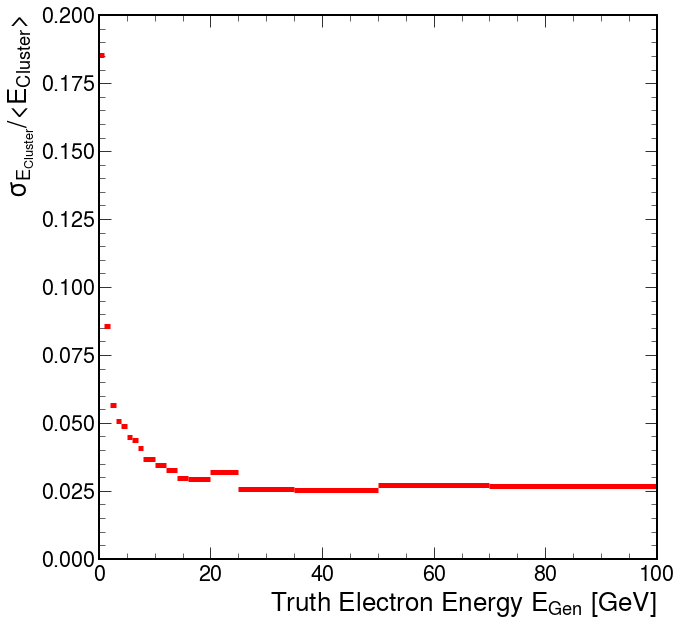

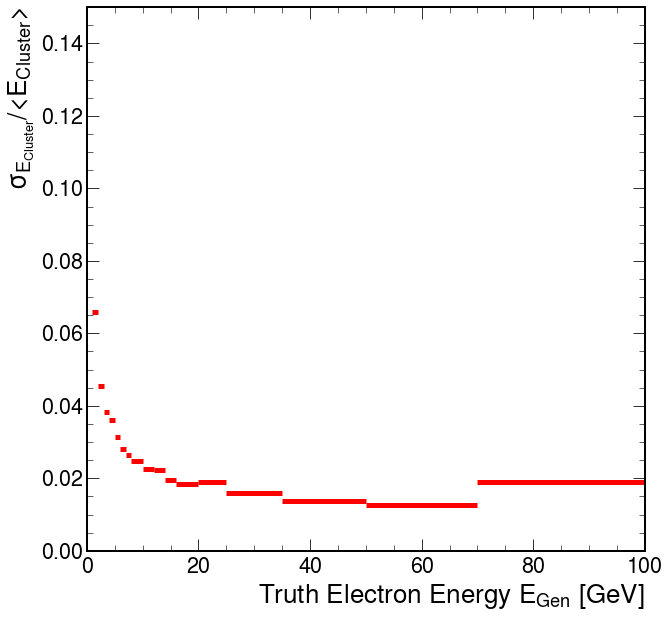

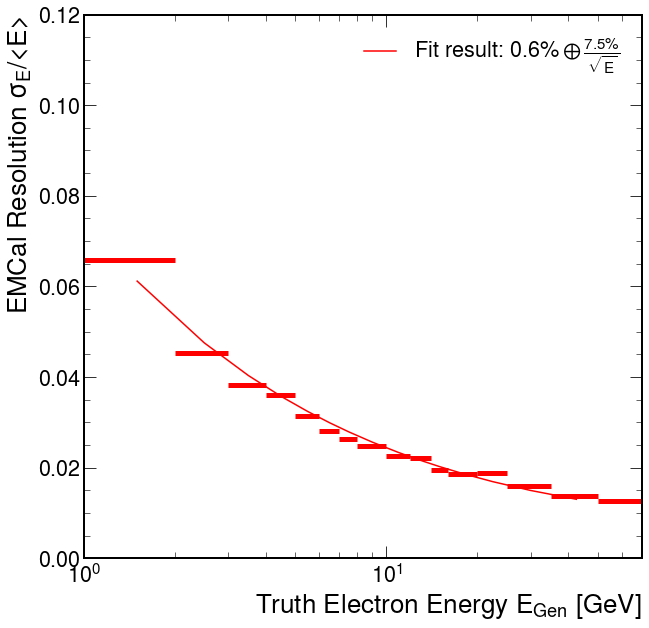

truth electron energy in the tenth bin:  [11.85894966 11.92533588 11.17411232 ... 11.86061573 11.68480682
 10.93753338]
binning:  0.0 1.0
[8.34817706e+00 3.08402292e-02 8.04239340e-02 3.06209923e-07]
binning:  1.0 2.0
[3.5139905  0.03622427 0.10434502 0.10079435]
binning:  2.0 3.0
[3.33164584 0.023442   0.12269603 0.10762248]
binning:  3.0 4.0
[2.79929293 0.02018788 0.14324687 0.13375351]
binning:  4.0 5.0
[2.64574082e+00 6.36192151e-04 1.24219572e-01 1.63533613e-01]
binning:  5.0 6.0
[2.20001822 0.03033811 0.17701016 0.17535327]
binning:  6.0 7.0
[2.10212776 0.04566504 0.18596015 0.17747219]
binning:  7.0 8.0
[1.87360359 0.07205352 0.23160622 0.18314644]
binning:  8.0 10.0
[1.72395808 0.05464351 0.23219545 0.21734873]
binning:  10.0 12.0
[1.53199123 0.07980433 0.26991738 0.23087294]
binning:  12.0 14.0
[1.39952945 0.05946341 0.27428144 0.27091741]
binning:  14.0 16.0
[1.22034457 0.14768615 0.39229945 0.24973499]
binning:  16.0 20.0
[1.16591096 0.14923891 0.37485015 0.27533761]
binning

<Figure size 720x720 with 0 Axes>

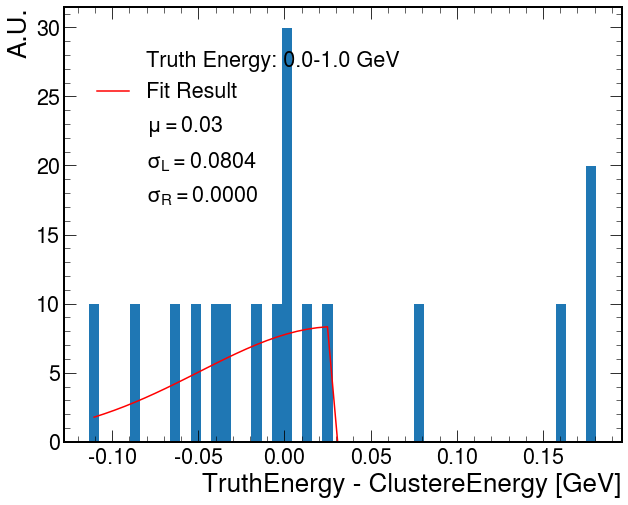

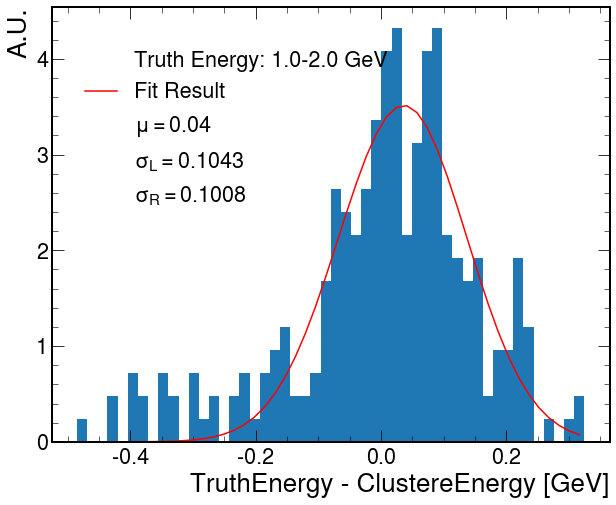

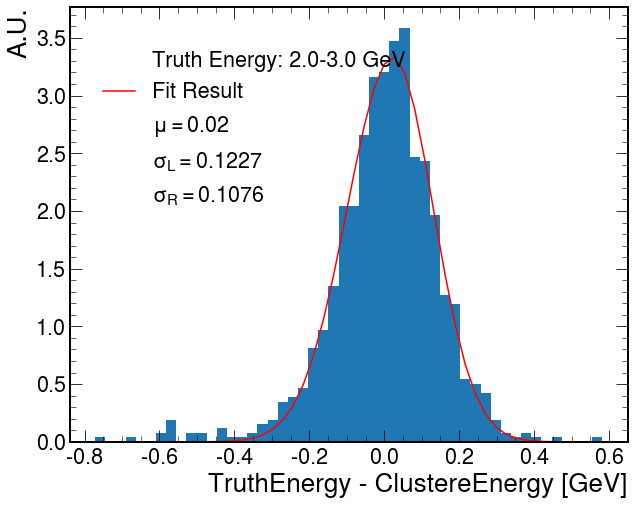

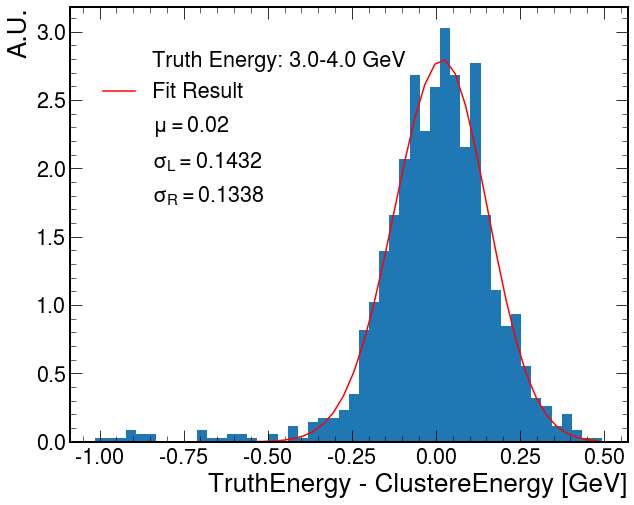

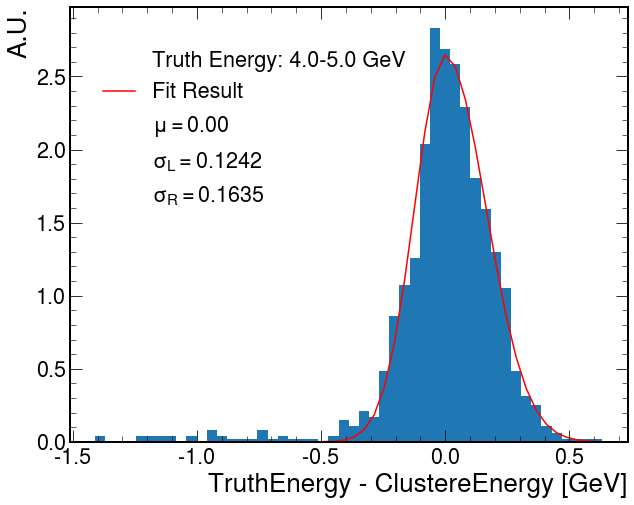

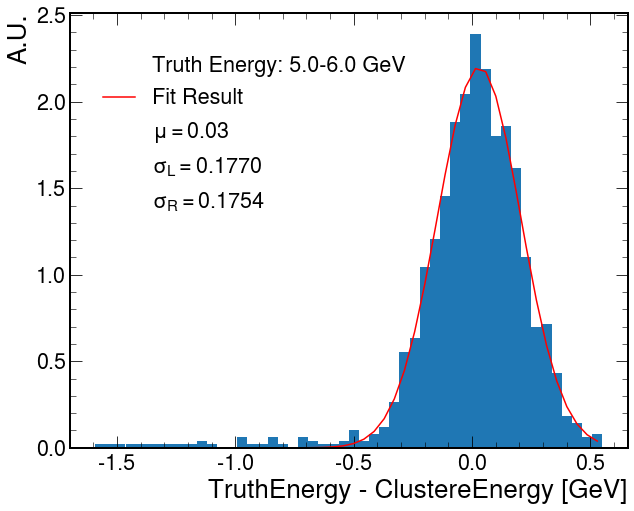

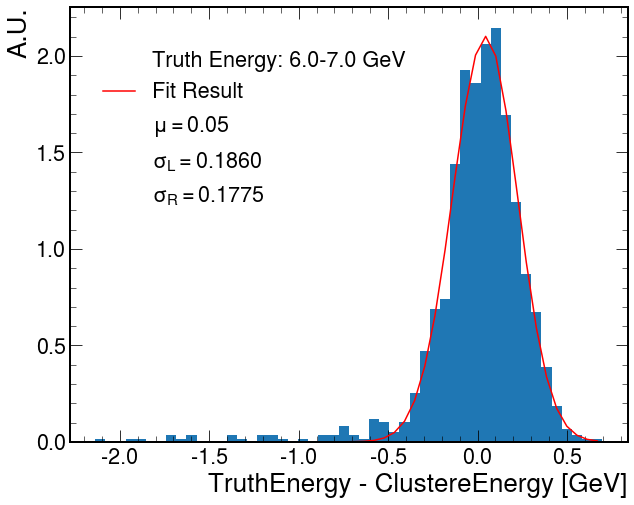

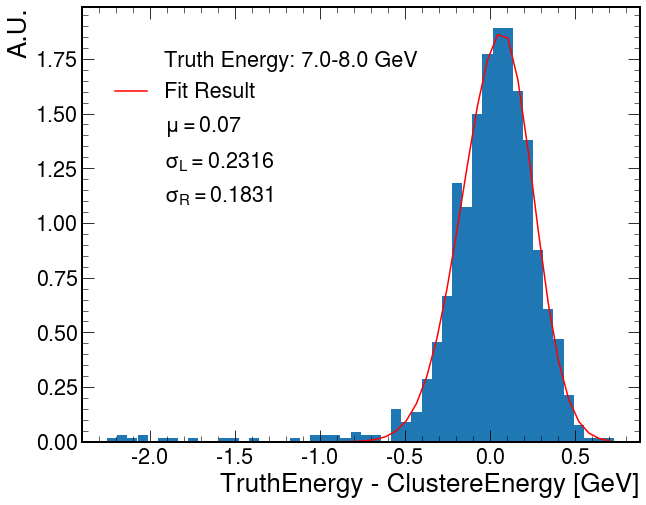

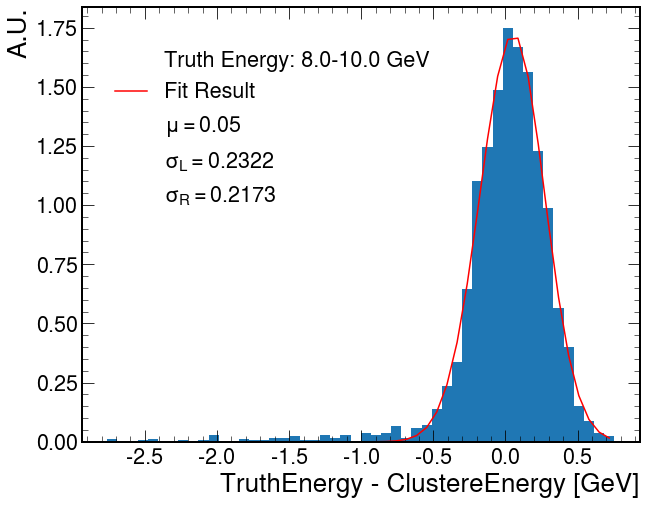

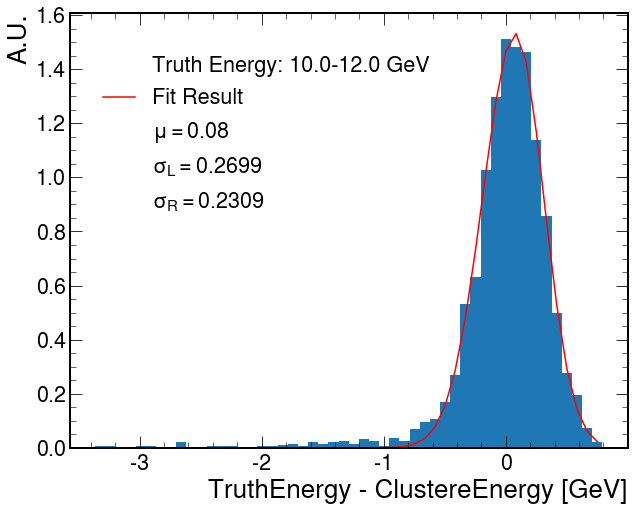

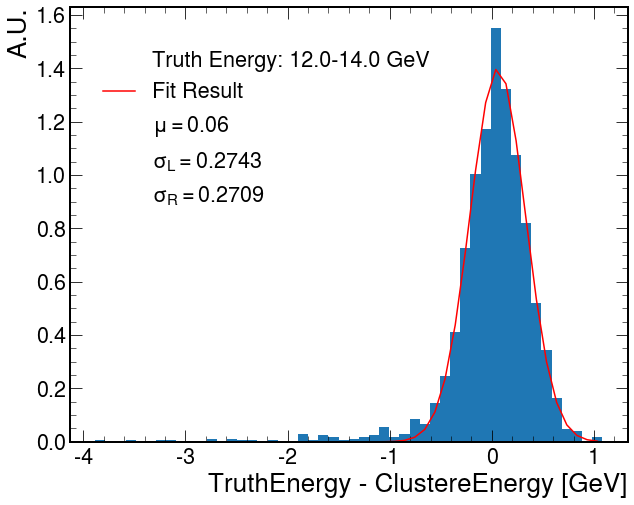

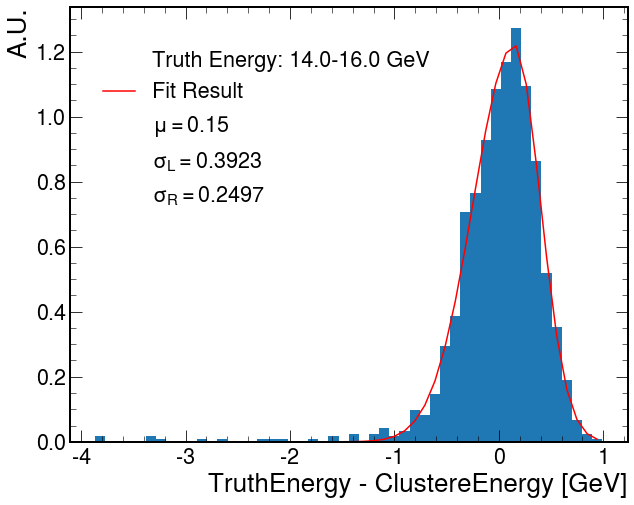

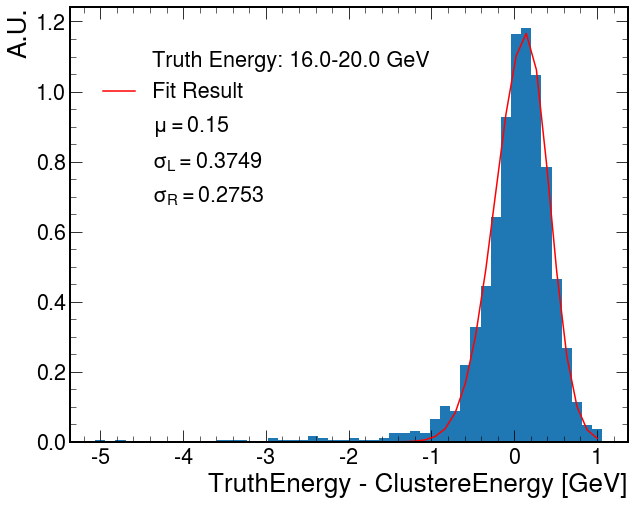

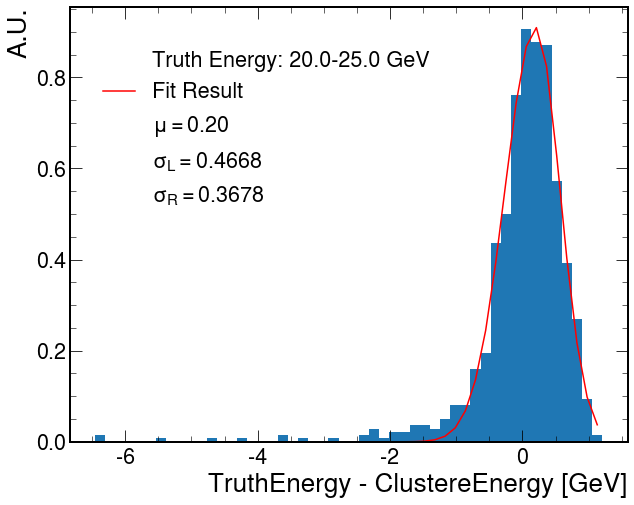

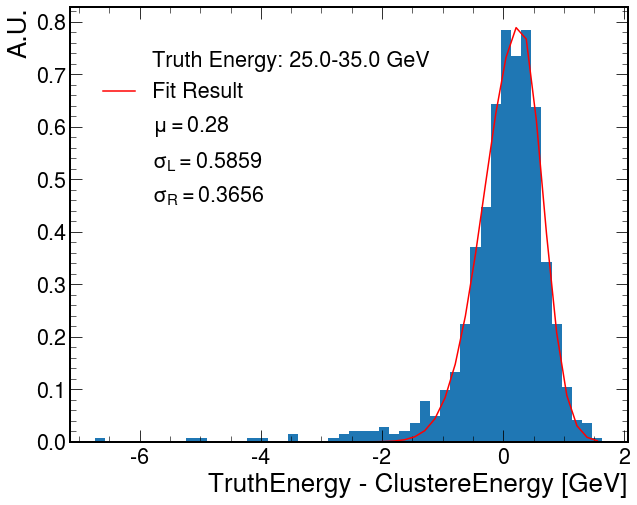

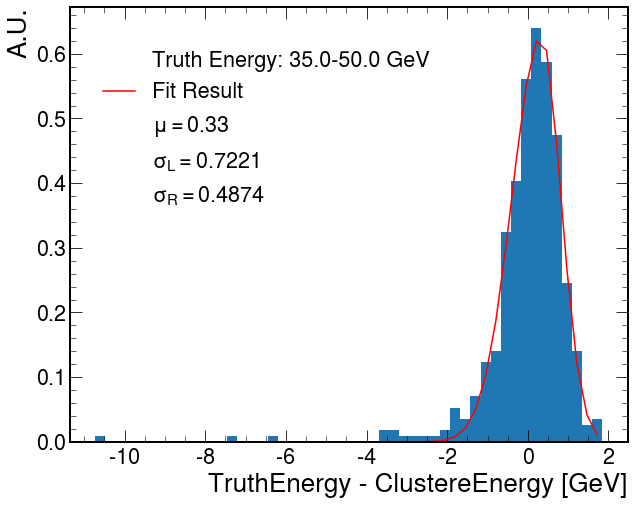

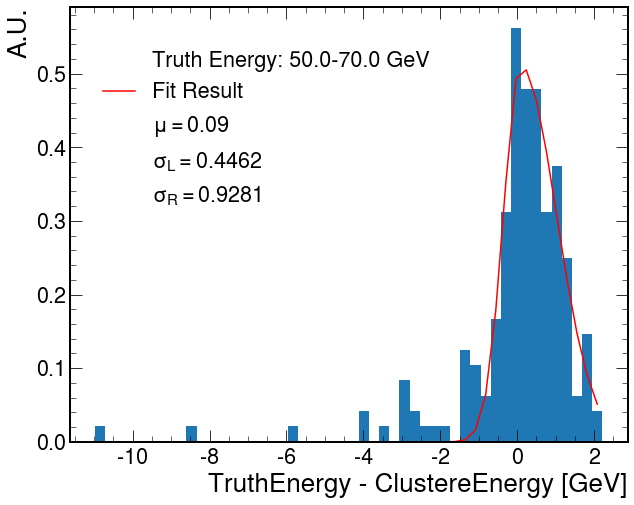

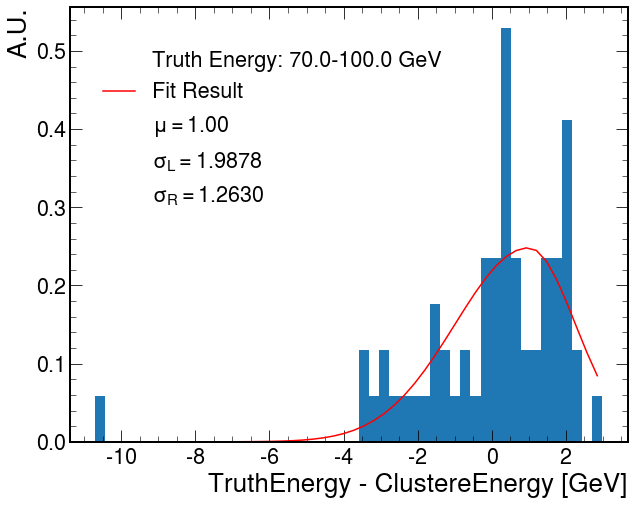

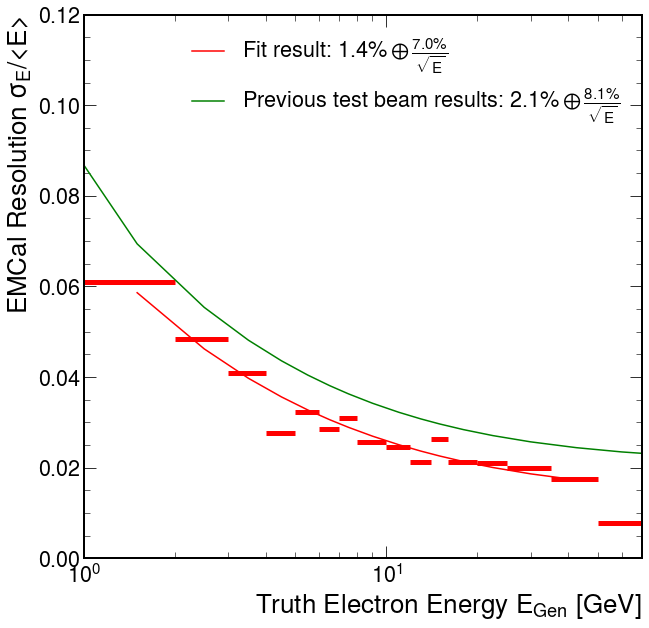

0.0017900419620765404 0.07109510999112231
<class 'numpy.ndarray'>
(0.021, 0.081)


<Figure size 720x720 with 0 Axes>

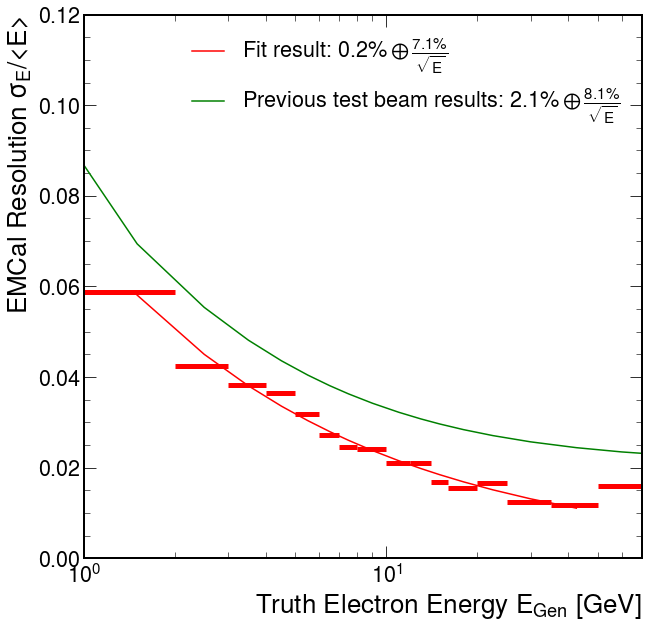

0.009354084710507506 0.07058427420025468
<class 'numpy.ndarray'>
(0.021, 0.081)


<Figure size 720x720 with 0 Axes>

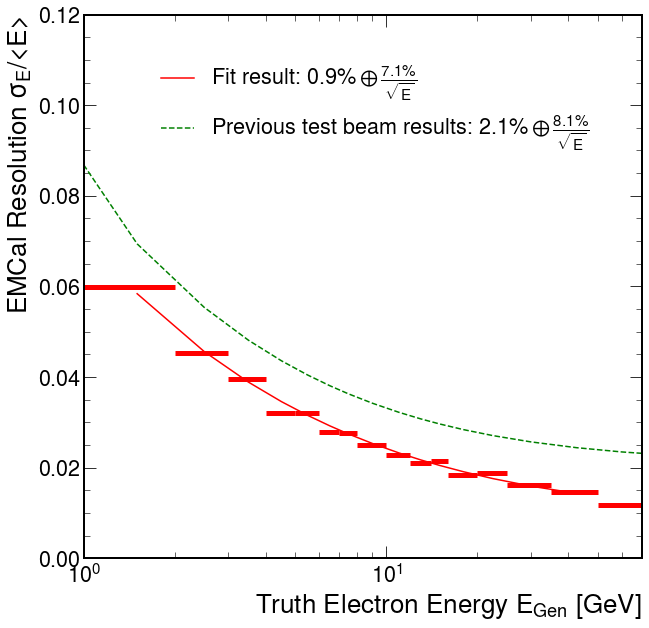

<Figure size 720x720 with 0 Axes>

In [56]:
#print(electron_truth)
def plotMeanAndResol(electron_truth_energy_array, cluster_energy_array):  
    from scipy.optimize import curve_fit
    def resolqt(y):
        return(np.percentile(y,84)-np.percentile(y,50))
        #return(np.percentile(y,50)-np.percentile(y,16))
    #print(electron_truth_energy_array)
    fig = plt.figure(figsize=(10,8))
    #binnings = np.concatenate((np.linspace(0,7,num=8), np.linspace(8, 14, num=4), np.linspace(16,20,num=2),np.linspace(30,70,num=5), np.linspace(80, 100, num=2)))
    binnings = np.concatenate((np.linspace(0,7,num=8), np.linspace(8, 14, num=4), np.linspace(16,20,num=2),np.array([25, 35, 50, 70, 100])))
    #binnings = np.linspace(0, 100, num=21)
    #binnings = np.concatenate((np.linspace(0,50, num=11), np.linspace(60,70, num=2), np.linspace(80,100, num=2)))
    print(binnings)
    print("digitize", np.digitize(electron_truth_energy_array, binnings))
    bin_avg,    bin_edges, binnumber = binned_statistic(electron_truth_energy_array, electron_truth_energy_array, statistic='mean', bins=binnings, range=(0,100))
    print("bin avg: ",bin_avg)
    bin_means, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_energy_array, statistic='mean', bins=binnings, range=(0,100))
    responses, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_energy_array/electron_truth_energy_array, statistic='mean', bins=binnings, range=(0,100))
    sfs = np.take(responses, np.digitize(electron_truth_energy_array, binnings)-1, mode='clip')
    print("scale factors ", sfs)
    bin_resols, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_energy_array - electron_truth_energy_array * sfs, statistic='std', bins=binnings, range=(0,100))
    bin_resol_qts, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_energy_array - electron_truth_energy_array * sfs, statistic=resolqt, bins=binnings, range=(0,100))

    bin_counts, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_energy_array, statistic='count', bins=binnings, range=(0,100))
    print(bin_resols)
    bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
    plt.hist2d(electron_truth_energy_array, cluster_energy_array, bins=[binnings,40], range=[[0,100], [0,12]], density=False, norm=colors.LogNorm())
    plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2,
           label='binned statistic of data', linestyles='solid')
    plt.errorbar(bin_centers, bin_means, yerr=bin_resols/np.sqrt(bin_counts),marker='.',color='r', linestyle="None")
    plt.xlim(0,70)
    plt.ylim(0,9)
    cbar=plt.colorbar()
    cbar.set_label('nElectrons')
    plt.xlabel("Truth Electron Energy [GeV]")
    plt.ylabel("Clustered Energy [GeV]")
    plt.savefig("Reco_VS_GenElectron_Energy.png")

    plt.figure()
    plt.hlines(bin_means/bin_avg, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
    plt.errorbar(bin_centers, bin_means, yerr=bin_resols/(np.sqrt(bin_counts)*bin_centers),marker='.',color='r', linestyle="None")
    plt.xlim(0,100.0)
    plt.ylim(0,0.15)
    plt.xlabel('Truth Electron Energy [GeV]')
    #plt.ylabel('<$E_{Cluster}$>/<$E_{Gen}$>')
    plt.ylabel('EMCal Response $<E_{Cluster}>$/$<E_{Truth}>$')
    plt.savefig("EMCal_Response.png")
        
    
    '''
    n, bins, patches = plt.hist(data_in_one_bin, bins=50, density=True)
    print("counts", n)
    print("bins", bins)
    print("count shape, ",n.shape[0], " bins shape ", bins.shape[0])
    (mu, sigma) = norm.fit(data_in_one_bin)
    (mu2, sigma2) = halfnorm.fit(data_in_one_bin)
    print("fitted sigma: ", sigma)
    print("quantiles: up ", np.percentile(data_in_one_bin,84)-np.percentile(data_in_one_bin,50), " down ", np.percentile(data_in_one_bin,50)-np.percentile(data_in_one_bin,16))
    sigma = np.percentile(data_in_one_bin,84)-np.percentile(data_in_one_bin,50)
    y = norm.pdf( bins, mu, sigma)
    #l = plt.plot(bins, y, 'r--', linewidth=2)
    #y2 = halfnorm.pdf( bins, mu, sigma)
    #l = plt.plot(bins, y2, 'g--', linewidth=2)
    #from scipy.optimize import curve_fit
    plotbins = [(bins[i]+bins[i+1])/2.0 for i in range(bins.shape[0]-1)]
    from scipy.optimize import curve_fit
    popt, pcov = curve_fit(func1, plotbins, n, bounds=(0, [10, 1.0,1.0, 1.0]))
    print(popt)
    #popt[3]=np.percentile(data_in_one_bin,84)-np.percentile(data_in_one_bin,50)
    #print(popt)

    plt.plot(plotbins, func1(plotbins, *popt), 'r-')
    '''
    
    
    #plt.xlim(-1,1)
    #plt.xlabel("TruthEnergy - ClustereEnergy [GeV]")
    #plt.ylabel('Entries')
    #plt.savefig("electron_energy_diff.png")

    plt.figure()
    plt.hlines(bin_resols/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
    plt.xlim(0,100.0)
    plt.ylim(0,0.20)
    plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
    plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
    
    plt.figure()
    plt.hlines(bin_resol_qts/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
    plt.xlim(0,100.0)
    plt.ylim(0,0.15)
    plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
    plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
    
    
    def func(x, a,b):
        return np.sqrt(a**2 + b**2/x) 
        #return a+b/np.sqrt(x)

    maxbin = np.digitize(np.array([40.0]), binnings)[0]
    print(bin_centers[1:maxbin], maxbin)
    
    minbin = 1


    popt, pcov = curve_fit(func, bin_centers[minbin:maxbin], (bin_resol_qts/bin_means)[minbin:maxbin], bounds=(0, [0.03, 0.1]))


    plt.figure()
    plt.hlines(bin_resol_qts/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           linestyles='solid')
    plt.xlim(1.0,70.0)
    plt.ylim(0,0.12)
    plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
    #plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
    plt.ylabel('EMCal Resolution $\sigma_{E}$/<E>')

    plt.xscale('log')
    plt.plot(bin_centers[minbin:maxbin], func(bin_centers[minbin:maxbin], *popt), 'r-',
         label=r'Fit result: $\mathrm{%5.1f\%% }\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
    print(*popt)
    print(type(popt))
    popt = np.array([0.021,0.081])
    print(tuple(popt))
    #plt.plot(bin_centers, func(bin_centers, *popt), 'g-',
    #     label=r'Previous test beam results: $\mathrm{%5.1f\%%}\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
    plt.legend()
    plt.show()
    plt.savefig("EMCal_Resolution.png")
    
    
    
    ### run fit to extract resolution
    # plot the truthEnergy-simEnergy in one bin
    #print("the tenth bin", np.where(np.digitize(electron_truth_energy_array, binnings)==10))
    print("truth electron energy in the tenth bin: ", electron_truth_energy_array[np.where(np.digitize(electron_truth_energy_array, binnings)==10)])
    from scipy.stats import norm, halfnorm
    data_in_one_bin = (1/sfs*cluster_energy_array - electron_truth_energy_array)[np.where(np.digitize(electron_truth_energy_array, binnings)==10)]
    
    def func1(x, a, mu, sigmaL,sigmaR):
        arg = x - mu
        coef = np.copy(x)
        coef[arg>0] = -0.5/(sigmaR*sigmaR)
        coef[arg<0] = -0.5/(sigmaL*sigmaL)
        #if arg > 0:
        #    coef = -0.5/(sigmaL*sigmaL);
        #else:
        #    coef = -0.5/(sigmaR*sigmaR);
        return a * np.exp(coef*arg*arg);
        
    def fitdata(data, postfix="", makePlot=True):
        n, bin_edges = np.histogram(data, bins=50, density=True)
        bincenters = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
        popt, pcov = curve_fit(func1, bincenters, n, bounds=(0, [10, 1.0,10.0, 10.0]))
        print(popt)
        
        if makePlot:
            fig = plt.figure(figsize=(10,8))
            plt.plot([],[], 'none', label="Truth Energy: "+ postfix + " GeV")
            plt.bar(bincenters, n, align='center', width=bin_edges[1]-bin_edges[0])
            plt.plot(bincenters, func1(bincenters, *popt), 'r-', label='Fit Result')
            plt.plot([],[], 'none', label=r'$\mu=%.2f$'%popt[1])
            plt.plot([],[], 'none', label=r'$\sigma_{L}=%.4f$'%popt[2])
            plt.plot([],[], 'none', label=r'$\sigma_{R}=%.4f$'%popt[3])
            plt.legend(loc="upper left", bbox_to_anchor=(0.02,0.95))
            #plt.show()
            #plt.xlim(-1,1)
            plt.xlabel("TruthEnergy - ClustereEnergy [GeV]")
            plt.ylabel('A.U.')
            plt.savefig("plots/electron_energy_diff" + postfix + ".png")
        return popt[2], popt[3]
    
    sigmaLs = []
    sigmaRs = []
    for ibin in range(binnings.shape[0]-1):
        print("binning: ", binnings[ibin], binnings[ibin+1])
        data_in_one_bin = (1/sfs*cluster_energy_array - electron_truth_energy_array)[np.where(np.digitize(electron_truth_energy_array, binnings)==ibin+1)]
        #print("data in one bin: ", data_in_one_bin)
        sigmaL, sigmaR = fitdata(data_in_one_bin, str(binnings[ibin])+"-"+str(binnings[ibin+1]))
        sigmaLs.append(sigmaL)
        sigmaRs.append(sigmaR)
        
    sigmaLs = np.array(sigmaLs)
    sigmaRs = np.array(sigmaRs)
    
    print("bin_means", bin_means.shape[0])
    print("sigmaLs", sigmaLs.shape[0])
    print("sigmaRs", sigmaRs.shape[0])
    
    popt, pcov = curve_fit(func, bin_centers[minbin:maxbin], (sigmaLs*responses/bin_means)[minbin:maxbin], bounds=(0, [0.03, 0.1]))
    plt.figure()
    plt.hlines(sigmaLs*responses/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           linestyles='solid')
    plt.xlim(1.0,70.0)
    plt.ylim(0,0.12)
    plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
    #plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
    plt.ylabel('EMCal Resolution $\sigma_{E}$/<E>')

    plt.xscale('log')
    plt.plot(bin_centers[minbin:maxbin], func(bin_centers[minbin:maxbin], *popt), 'r-',
         label=r'Fit result: $\mathrm{%5.1f\%% }\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
    print(*popt)
    print(type(popt))
    popt = np.array([0.021,0.081])
    print(tuple(popt))
    plt.plot(bin_centers, func(bin_centers, *popt), 'g-',
         label=r'Previous test beam results: $\mathrm{%5.1f\%%}\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
    plt.legend()
    plt.show()
    plt.savefig("EMCal_Resolution.png")
    
    ###
    popt, pcov = curve_fit(func, bin_centers[minbin:maxbin], (sigmaRs*responses/bin_means)[minbin:maxbin], bounds=(0, [0.03, 0.1]))
    plt.figure()
    plt.hlines(sigmaRs*responses/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           linestyles='solid')
    plt.xlim(1.0,70.0)
    plt.ylim(0,0.12)
    plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
    #plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
    plt.ylabel('EMCal Resolution $\sigma_{E}$/<E>')

    plt.xscale('log')
    plt.plot(bin_centers[minbin:maxbin], func(bin_centers[minbin:maxbin], *popt), 'r-',
         label=r'Fit result: $\mathrm{%5.1f\%% }\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
    print(*popt)
    print(type(popt))
    popt = np.array([0.021,0.081])
    print(tuple(popt))
    plt.plot(bin_centers, func(bin_centers, *popt), 'g-',
         label=r'Previous test beam results: $\mathrm{%5.1f\%%}\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
    plt.legend()
    plt.show()
    plt.savefig("EMCal_Resolution.png")
    
    ## average of (sigmaL + sigmaR)
    popt, pcov = curve_fit(func, bin_centers[minbin:maxbin], ((sigmaLs+sigmaRs)/2.0*responses/bin_means)[minbin:maxbin], bounds=(0, [0.03, 0.1]))
    plt.figure()
    plt.hlines((sigmaLs+sigmaRs)/2.0*responses/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           linestyles='solid')
    plt.xlim(1.0,70.0)
    plt.ylim(0,0.12)
    plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
    #plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
    plt.ylabel('EMCal Resolution $\sigma_{E}$/<E>')

    plt.xscale('log')
    plt.plot(bin_centers[minbin:maxbin], func(bin_centers[minbin:maxbin], *popt), 'r-',
         label=r'Fit result: $\mathrm{%5.1f\%% }\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
    print(*popt)
    print(type(popt))
    popt = np.array([0.021,0.081])
    print(tuple(popt))
    plt.plot(bin_centers, func(bin_centers, *popt), 'g--',
         label=r'Previous test beam results: $\mathrm{%5.1f\%%}\oplus \frac{%5.1f\%%}{\sqrt{E}}$' %(popt[0]*100.0, popt[1]*100.0))
    plt.legend(loc="upper left", bbox_to_anchor=(0.10,0.95))
    plt.show()
    plt.savefig("EMCal_Resolution.png")
    
plotMeanAndResol(electron_truth_energy_array, cluster_energy_array)

In [108]:
def func(x, a,b):
    return np.sqrt(a**2 / x + b**2) 

print(bin_centers[1:11])

from scipy.optimize import curve_fit
popt, pcov = curve_fit(func, bin_centers[2:11], (bin_resol_qts/bin_means)[2:11], bounds=(0, [1.0, 0.045]))

plt.figure()
plt.hlines(bin_resols/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.xlim(0,100.0)
plt.ylim(0,0.10)
plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')
plt.plot(bin_centers[:11], func(bin_centers[:11], *popt), 'r-',
         label='fit: a=%5.3f b=%5.3f' % tuple(popt))
plt.legend()
plt.show()


[3.0, 5.0, 7.0, 10.0, 14.0, 18.0, 25.0, 35.0, 45.0, 55.0]


NameError: name 'bin_resol_qts' is not defined

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  60.  70.  80.
 100.]


Text(0, 1, '$\\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')

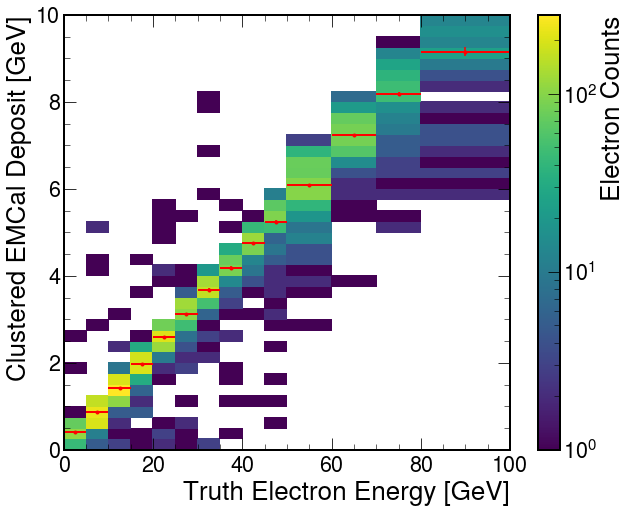

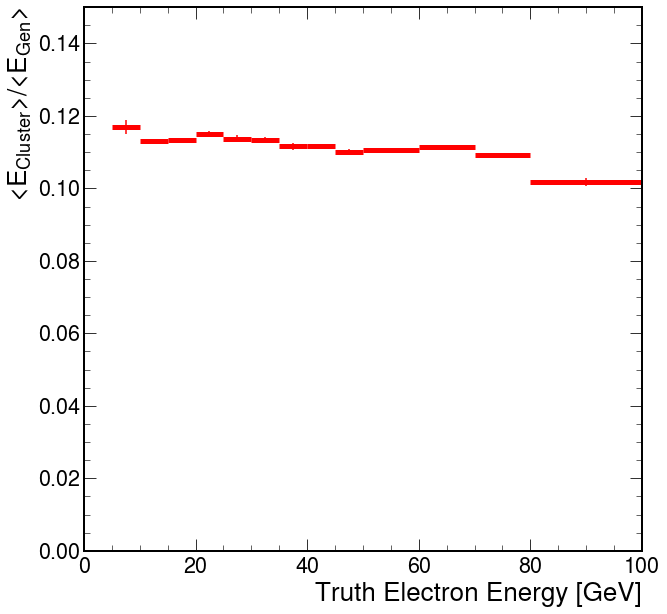

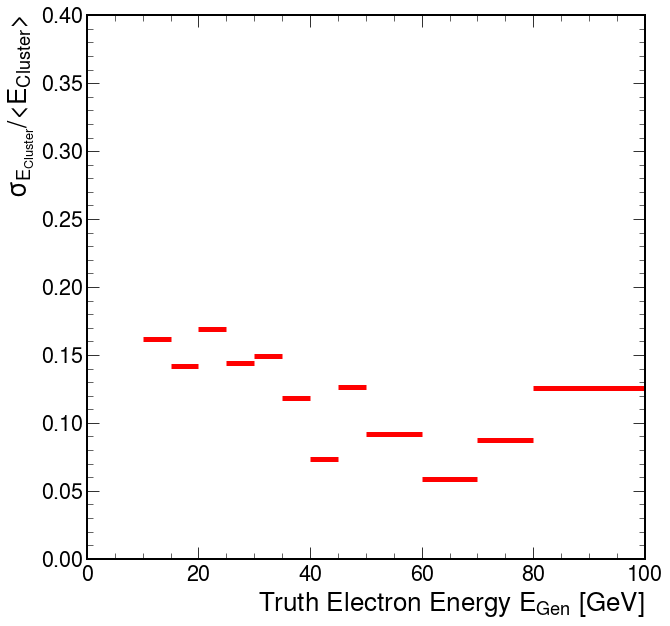

In [134]:
#print(electron_truth)
from scipy.stats import binned_statistic
#print(electron_truth_energy_array)
fig = plt.figure(figsize=(10,8))
#binnings = np.concatenate((np.linspace(0,10,num=11), np.linspace(11,19,num=5),np.linspace(21,31,num=3), np.linspace(41, 101, num=11)))
binnings = np.concatenate((np.linspace(0,50, num=11), np.linspace(60,70, num=2), np.linspace(80,100, num=2)))
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
print(binnings)
bin_resols, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_truth_array, statistic='std', bins=binnings, range=(0,100))
bin_means, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_truth_array, statistic='mean', bins=binnings, range=(0,100))
bin_counts, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_truth_array, statistic='count', bins=binnings, range=(0,100))
plt.hist2d(electron_truth_energy_array, cluster_truth_array, bins=[binnings,40], range=[[0,100], [0,10]], density=False, norm=colors.LogNorm())
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=2,
           label='binned statistic of data', linestyles='solid')
plt.errorbar(bin_centers, bin_means, yerr=bin_resols/np.sqrt(bin_counts),marker='.',color='r', linestyle="None")
plt.xlim(0,100)
plt.ylim(0,10)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Deposit [GeV]")
plt.savefig("Reco_VS_GenElectron_Energy.png")

plt.figure()
plt.hlines(bin_means/bin_centers, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.errorbar(bin_centers, bin_means/bin_centers, yerr=bin_resols/(np.sqrt(bin_counts)*bin_centers),marker='.',color='r', linestyle="None")
plt.xlim(0,100.0)
plt.ylim(0,0.15)
plt.xlabel('Truth Electron Energy [GeV]')
plt.ylabel('<$E_{Cluster}$>/<$E_{Gen}$>')
plt.figure()
plt.hlines(bin_resols/bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
           label='binned statistic of data', linestyles='solid')
plt.xlim(0,100.0)
plt.ylim(0,0.4)
plt.xlabel('Truth Electron Energy $E_{Gen}$ [GeV]')
plt.ylabel('$\sigma_{E_{Cluster}}$/<$E_{Cluster}$>')

Text(0, 1, 'Clustered EMCal Size')

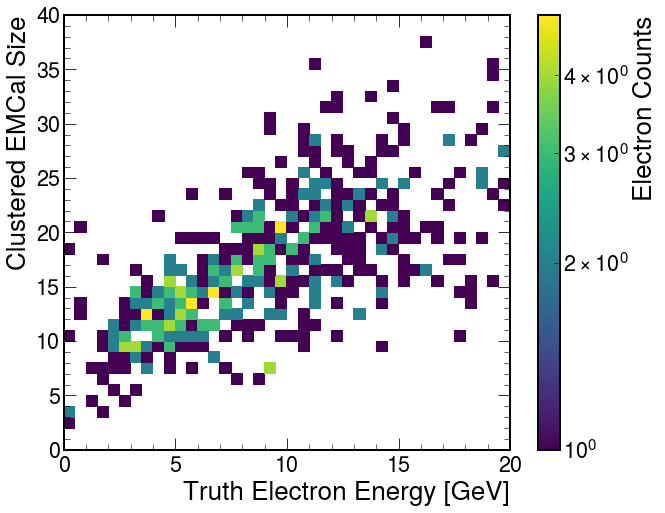

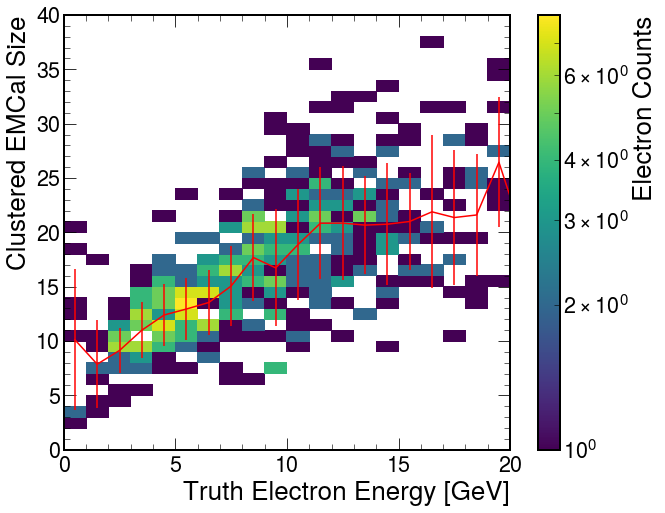

In [103]:
fig = plt.figure(figsize=(10,8))
cluster_size_array = np.array(cluster_size_1st+cluster_size_2nd)
cluster_size_array = cluster_size_array[mask_outliers]
plt.hist2d(electron_truth_energy_array, cluster_size_array, bins=[40,40], range=[[0,20], [0,40]], density=False, norm=colors.LogNorm())
#plt.xlim(0,8)
#plt.ylim(0,8)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Size")
plt.savefig("RecoSize_VS_Gen_Energy.png")

from scipy.stats import binned_statistic
fig = plt.figure(figsize=(10,8))
binnings = np.concatenate((np.linspace(0,20,num=21), np.linspace(21,31,num=3), np.linspace(41, 51, num=2)))
bin_resols, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_size_array, statistic='std', bins=binnings, range=(0,40))
bin_means, bin_edges, binnumber = binned_statistic(electron_truth_energy_array, cluster_size_array, statistic='mean', bins=binnings, range=(0,40))
plt.hist2d(electron_truth_energy_array, cluster_size_array, bins=[binnings,40], range=[[0,20], [0,40]], density=False, norm=colors.LogNorm())
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='r', lw=5,
#           label='binned statistic of data', linestyles='solid')
bin_centers = [(bin_edges[i]+bin_edges[i+1])/2.0 for i in range(bin_edges.shape[0]-1)]
plt.errorbar(bin_centers, bin_means, bin_resols,color='r')
plt.xlim(0,20)
#plt.ylim(0,8)
cbar=plt.colorbar()
cbar.set_label('Electron Counts')
plt.xlabel("Truth Electron Energy [GeV]")
plt.ylabel("Clustered EMCal Size")
#plt.savefig("Reco_VS_GenElectron_Energy.png")